<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-all-sessions" data-toc-modified-id="Load-all-sessions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load all sessions</a></span><ul class="toc-item"><li><span><a href="#JG14190621" data-toc-modified-id="JG14190621-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>JG14190621</a></span></li><li><span><a href="#JG14_190619" data-toc-modified-id="JG14_190619-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>JG14_190619</a></span></li><li><span><a href="#JG14_190626" data-toc-modified-id="JG14_190626-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>JG14_190626</a></span></li><li><span><a href="#JG15_190722" data-toc-modified-id="JG15_190722-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>JG15_190722</a></span></li><li><span><a href="#JG15_190725" data-toc-modified-id="JG15_190725-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>JG15_190725</a></span></li><li><span><a href="#JG18a_190814" data-toc-modified-id="JG18a_190814-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>JG18a_190814</a></span></li><li><span><a href="#JG18b_190828" data-toc-modified-id="JG18b_190828-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>JG18b_190828</a></span></li></ul></li><li><span><a href="#Behaviour-Analysis" data-toc-modified-id="Behaviour-Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Behaviour Analysis</a></span></li><li><span><a href="#Spike-Analysis" data-toc-modified-id="Spike-Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Spike Analysis</a></span></li></ul></div>

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import scipy.stats as st
import importlib
import os
import sys
import platform
import qgrid
import datetime
from scipy.interpolate import make_interp_spline, BSpline
import pickle

from sync_class import SyncPhenosys
from spikes_class import SpikeAnalysis
from behavior_class import BehaviorAnalysis


%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

%matplotlib notebook
%config InlineBackend.figure_format = 'retina'
#plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))




# ============================================================================================================================
# specify file path & sessions

windows_folder = r"C:/Users/User/Google Drive/3 Projekte/Masterarbeit Laborarbeit Neuroscience/1 Data Analysis"
linux_folder = "/home/max/ExpanDrive/Google Drive/3 Projekte/Masterarbeit Laborarbeit Neuroscience/1 Data Analysis"
mac_folder = "/Users/max/Google Drive/3 Projekte/Masterarbeit Laborarbeit Neuroscience/1 Data Analysis"

# list -> [ session_name, [ttl_missing_rows], load_spikes, [spikes_trials_skip] ]
se_li = [('JG14_190621', [1900,1931,1996,2058,2127],True,[(0,6),(215,'end')]),
         ('JG14_190619', [111, 2781],False,[]),
         ('JG14_190626', [1428, 1824, 1838, 2861, 2910, 3089, 3245, 3430, 3443],False,[]),
         ('JG15_190722', [2094, 2574, 2637, 2808, 2831, 3499],False,[]),
         ('JG15_190725', [366,711,1487,1578,1659,2221,2666,2720,2769,2847,3371,3476],False,[]),
         ('JG18a_190814', [405,2621,2693,2770,2959,3015,3029,3038,3048],False,[]),
         ('JG18b_190828', [1744, 2363, 2648, 2701, 2731, 2778,2953,2967],True,[]),
         ]



# ============================================================================================================================
# Load sessions functions

def add_session(session, gamble_side, sync_obj, missing_rows_ttl, combined, trials, behavior, spikes, trials_skip):
    session_dict = {
        'session':session,
        'gamble_side':gamble_side,
        #'sync_obj':sync_obj,
        'missing_rows_ttl':missing_rows_ttl,
        'combined':combined,
        'trials':trials,
        'behavior':behavior,
        'trials_skip':trials_skip,
    }
    if spikes != False:
        session_dict['spikes']=spikes
        
    # add session dict to all sessions dict
    all_sessions_dict[session]=session_dict
    return session_dict


def load_session(session, missing_rows_ttl=[], lo_spikes=False, trials_skip=[]):

    # load calss and set folder depending on platform

    # load calss and set folder depending on platform
    if platform.system() == 'Linux':
        # Linux
        folder = linux_folder + '/' + session
    elif platform.system() == 'Windows':
        # windows
        folder = windows_folder + r"/" + session
    elif platform.system() == 'Darwin':
        folder = mac_folder + r"/" + session

    sync_obj = SyncPhenosys(session, folder, 7, 1, missing_rows_ttl)   
    #gamble_side = sync_obj.gamble_side

    # first find missing rows
    #missing_rows_csv = []
    #combined = sync_obj.combine_dataframes(missing_rows_ttl, missing_rows_csv, 'channel 1', sync_obj.csv, False)
    #trials_df = sync_obj.get_trials(combined)
    behavior = BehaviorAnalysis(session, folder, sync_obj)

    if lo_spikes:
        spikes = SpikeAnalysis(session, folder, sync_obj)
        for a,b in trials_skip:
            if b == 'end':
                spikes.trials_df.loc[a:,'select'] = False
            else:
                spikes.trials_df.loc[a:b,'select'] = False
    else:
        spikes = False

    return session, gamble_side, sync_obj, behavior_obj, spikes_obj


def load_all_sessions(se_li):
    all_sessions = dict()
    for session, missing_rows_ttl, lo_spikes, trials_skip in se_li:
        session, gamble_side, sync_obj, combined, trials, behavior, spikes = load_session(session, missing_rows_ttl, lo_spikes, trials_skip)
        
        session_dict = add_session(session, gamble_side, sync_obj, missing_rows_ttl, combined, trials, behavior, spikes, trials_skip)  
        all_sessions[session]=session_dict

    return all_sessions


        
# ============================================================================================================================
# save & load sessions from pickl functions

# save dict to pickl
def save_all_sessions_dict_pickl():
    if platform.system() == 'Linux':
        # Linux
        folder = linux_folder
    elif platform.system() == 'Windows':
        # windows
        folder = windows_folder
    elif platform.system() == 'Darwin':
        folder = mac_folder 
        
    file = folder + '/all_sessions_dict.pkl'
    with open(file, 'wb') as dump:
        pickle.dump(all_sessions_dict, dump)

# load dict from pickl
def load_all_sessions_dict_pickl():
    if platform.system() == 'Linux':
        # Linux
        folder = linux_folder
    elif platform.system() == 'Windows':
        # windows
        folder = windows_folder
    elif platform.system() == 'Darwin':
        folder = mac_folder 
        
    file = folder + '/all_sessions_dict.pkl'
    
    with open(file, 'rb') as dump:
        all_sessions_dict = pickle.load(dump)
    return all_sessions_dict

/opt/anaconda3/envs/spikes/lib/python3.8/site-packages/IPython/extensions/autoreload.py:245: PerformanceWarning: indexing past lexsort depth may impact performance.
  superreload(m, reload, self.old_objects)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of sync_class failed: Traceback (most recent call last):
  File "/opt/anaconda3/envs/spikes/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/anaconda3/envs/spikes/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/opt/anaconda3/envs/spikes/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/opt/anaconda3/envs/spikes/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 783, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/sync_class.py", line 459, in <module>
    sync_obj = SyncPhenosys(session, folder, 7, 1, r

In [348]:
all_sessions_dict = load_all_sessions(se_li)
#load_all_sessions(all_sessions_dict, se_li)

/opt/anaconda3/envs/spikes/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: PerformanceWarning: indexing past lexsort depth may impact performance.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda3/envs/spikes/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: PerformanceWarning: indexing past lexsort depth may impact performance.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda3/envs/spikes/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: PerformanceWarning: indexing past lexsort depth may impact performance.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda3/envs/spikes/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: PerformanceWarning: indexing past lexsort depth may impact performance.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda3/envs/spikes/lib/python3.8/site-packages/IPython/core/inte

In [349]:
#all_sessions_dict = load_all_sessions_dict_pickl()
for key in all_sessions_dict.keys():
    print(key)

JG14_190621
JG14_190619
JG14_190626
JG15_190722
JG15_190725
JG18a_190814
JG18b_190828


In [334]:
load_session('JG14_190619', [111, 2781],False,[])

/opt/anaconda3/envs/spikes/lib/python3.8/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


non


('JG14_190619',
 'right',
                                     TTL Start  TTL Length TTL Event  \
 All Trial Trial index Group Index                                     
 0.0       0.0   0     0              359352.0        21.0     start   
                 1     1              379614.0        40.0       cue   
                 2     2              380253.0       218.0       end   
                 3     3              381155.0        98.0  right_rw   
                 4     4              483200.0       140.0   left_rw   
 ...                                       ...         ...       ...   
 1143.0    278.0 3682  6            26486281.0       218.0       end   
 NaN       NaN   3683  0            26486539.0        21.0     start   
                 3684  1            26506600.0        40.0       cue   
                 3685  2            26507240.0        60.0     sound   
                 3686  3            26507920.0        80.0  openloop   
 
                                    

In [350]:
save_all_sessions_dict_pickl()

---

In [ ]:
all_sessions_dict = load_all_sessions_dict_pickl()

In [ ]:
for key in all_sessions_dict.keys():
    print(key)

---

# Load all sessions

## JG14190621

In [7]:
session = 'JG14_190621'

# load calss and set folder depending on platform
if platform.system() == 'Linux':
    # Linux
    folder = linux_folder + '/' + session
elif platform.system() == 'Windows':
    # windows
    folder = windows_folder + r"/" + session
elif platform.system() == 'Darwin':
    folder = mac_folder + r"/" + session

In [9]:

sync_obj = SyncPhenosys(session, folder, 7, 1)    


# first find missing rows
missing_rows_ttl = [1900,1931,1996,2058,2127]
missing_rows_csv = []
combined = sync_obj.combine_dataframes(missing_rows_ttl, missing_rows_csv, 'channel 1', sync_obj.csv, False)

qgrid.show_grid(combined)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [10]:
trials = sync_obj.get_trials(combined)
qgrid.show_grid(trials)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [11]:
sync_obj.ttl_info_channel

,Start,Length,Event
1,184261,17,start
3,204966,39,cue
5,205627,61,sound
7,206346,80,openloop
9,346501,178,no response in time
...,...,...,...
4333,22450560,216,end
4335,22450817,21,start
4337,22470860,37,cue
4339,22471517,61,sound


<IPython.core.display.Javascript object>


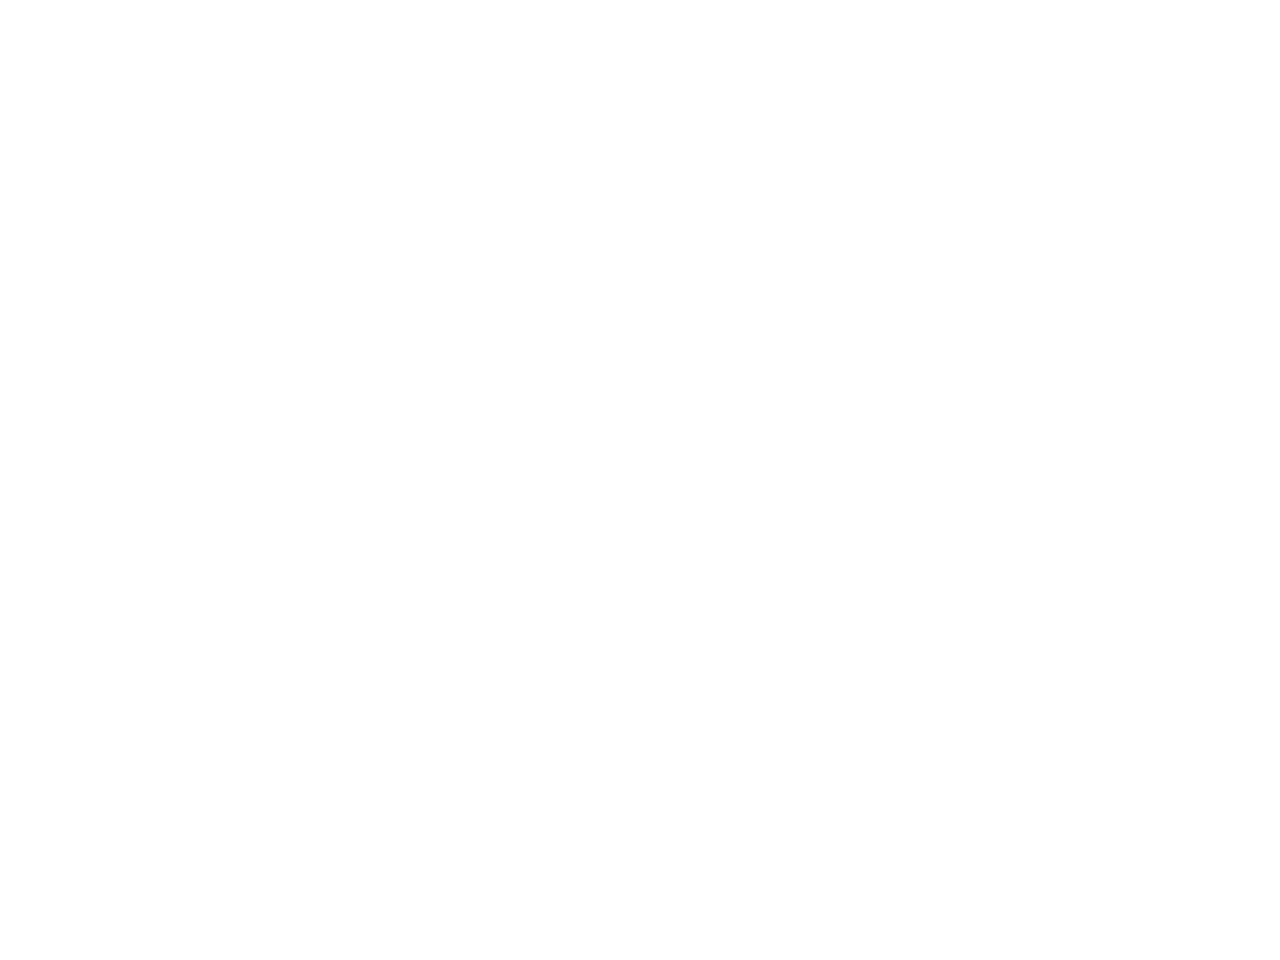

In [12]:
plt.figure()
combined['Delta (TTL-CSV)'].plot()
plt.show()

---

In [13]:
 behavior = BehaviorAnalysis(session, folder, combined)


<IPython.core.display.Javascript object>


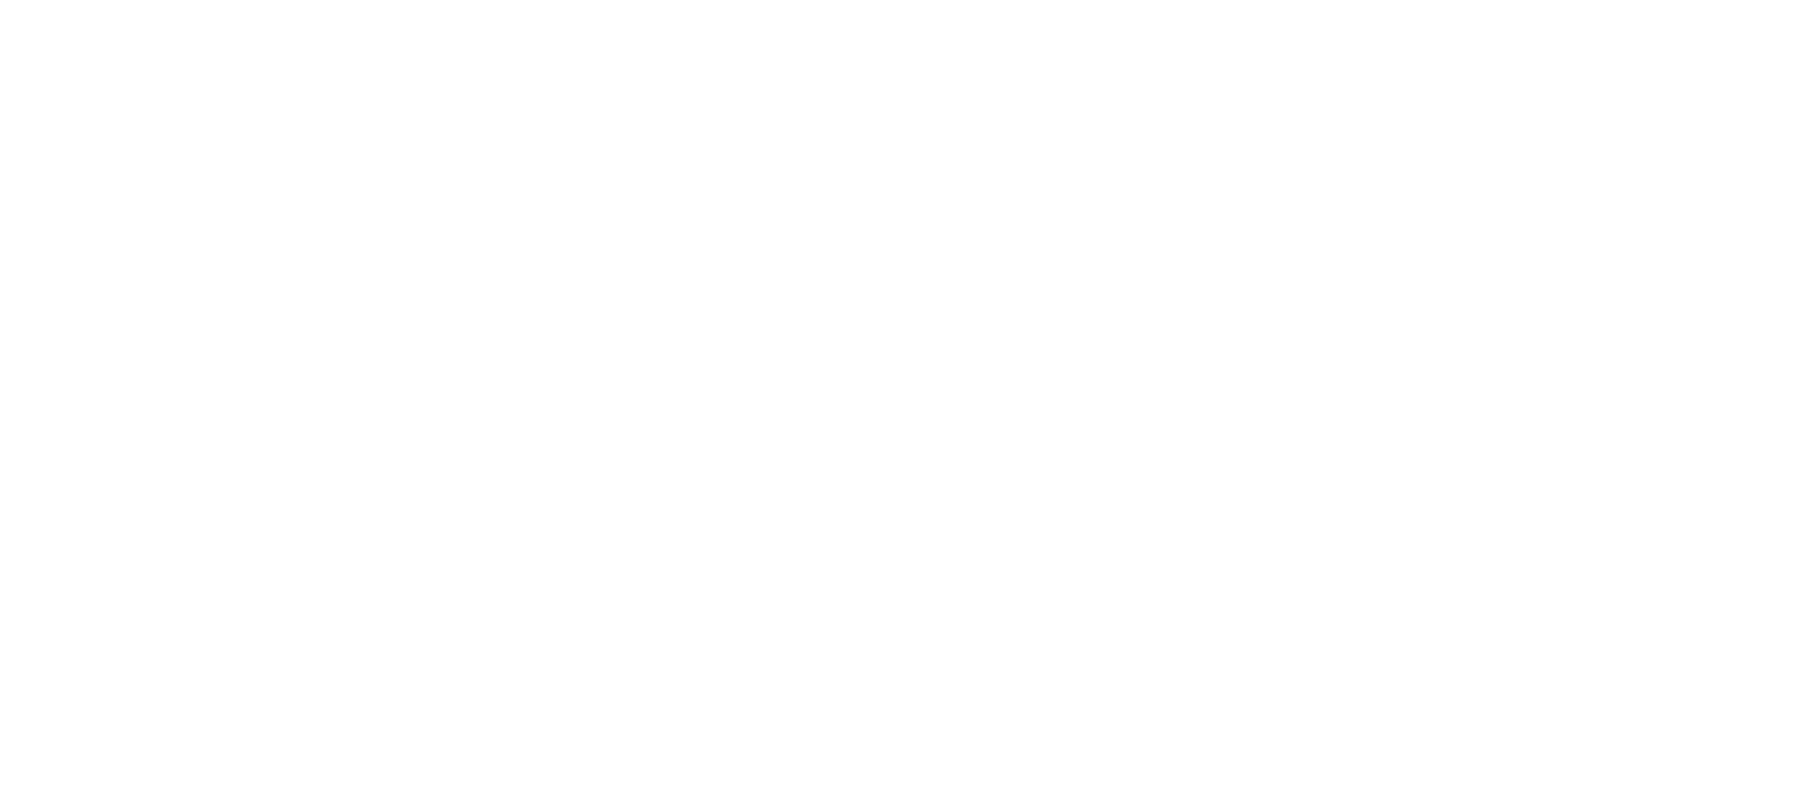

In [14]:
behavior.plot_wheel_resp()


---

In [15]:
spikes = SpikeAnalysis(session, folder, gambl_side)
spikes.trials_df.loc[0:6, 'select'] = False
spikes.trials_df.loc[215:, 'select'] = False
qgrid.show_grid(spikes.trials_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [16]:
add_session(session, gambl_side, sync_obj, missing_rows_ttl, trials, behavior, spikes)

## JG14_190619

In [17]:
session = 'JG14_190619'

# load calss and set folder depending on platform
if platform.system() == 'Linux':
    # Linux
    folder = linux_folder + '/' + session
elif platform.system() == 'Windows':
    # windows
    folder = windows_folder + r"/" + session
elif platform.system() == 'Darwin':
    folder = mac_folder + r"/" + session

In [18]:
sync_obj = SyncPhenosys(session, folder, 7, 1)  
missing_rows_ttl = [111, 2781]
missing_rows_csv = []
combined = sync_obj.combine_dataframes(missing_rows_ttl, missing_rows_csv, 'channel 1', sync_obj.csv, False)

gambl_side = sync_obj.gambl_side

qgrid.show_grid(combined)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [19]:
trials = sync_obj.get_trials(combined)
qgrid.show_grid(trials)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [20]:
sync_obj.ttl_info_channel

,Start,Length,Event
1,359352,21,start
3,379614,40,cue
5,380253,218,end
7,381155,98,right_rw
9,483200,140,left_rw
...,...,...,...
5631,26486281,218,end
5633,26486539,21,start
5635,26506600,40,cue
5637,26507240,60,sound


<IPython.core.display.Javascript object>


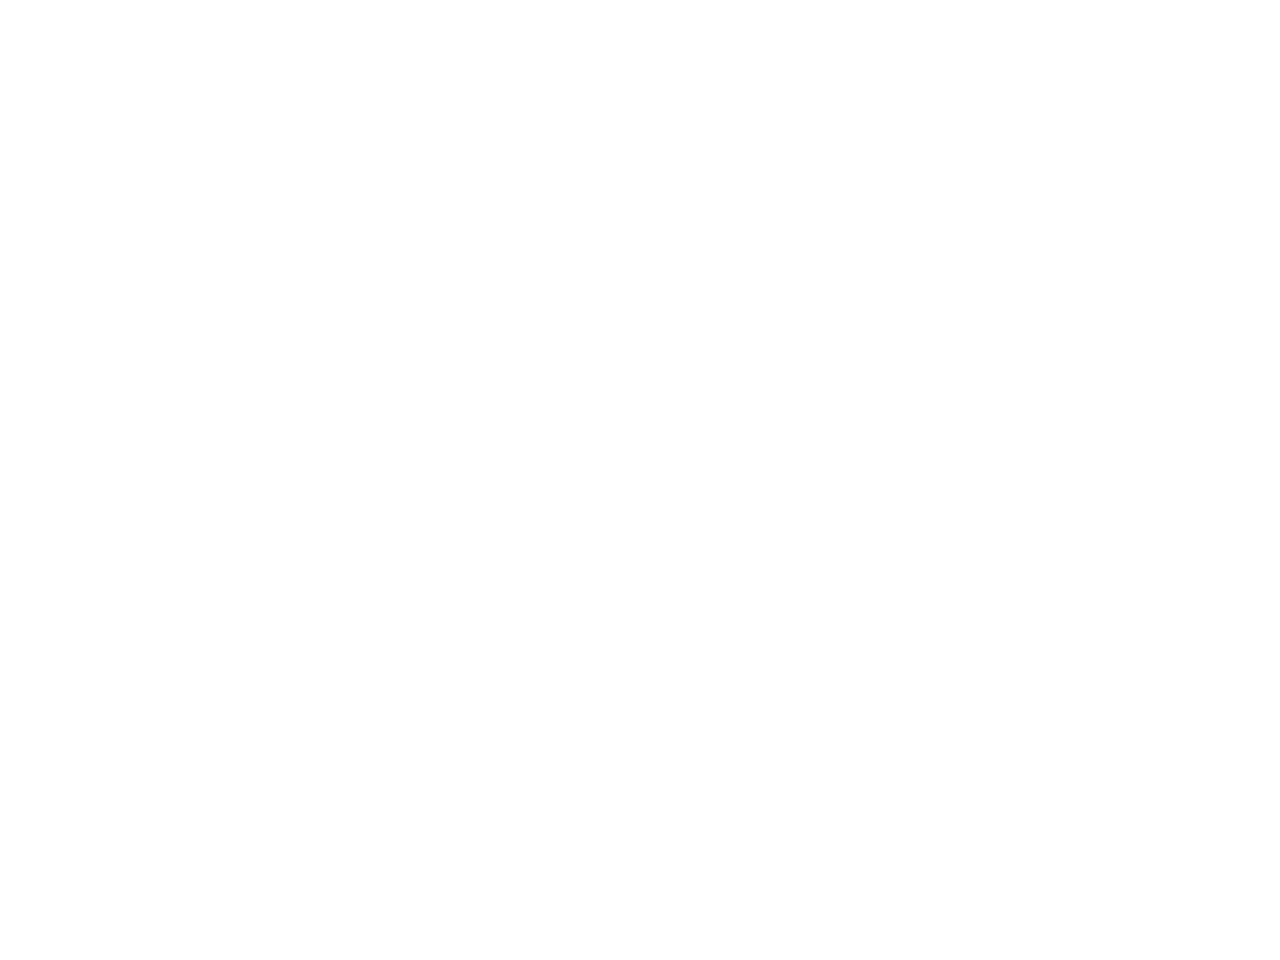

In [21]:
plt.figure()
combined['Delta (TTL-CSV)'].plot()
plt.show()

---

In [22]:
 behaviour = BehaviorAnalysis(session, folder, combined)


<IPython.core.display.Javascript object>


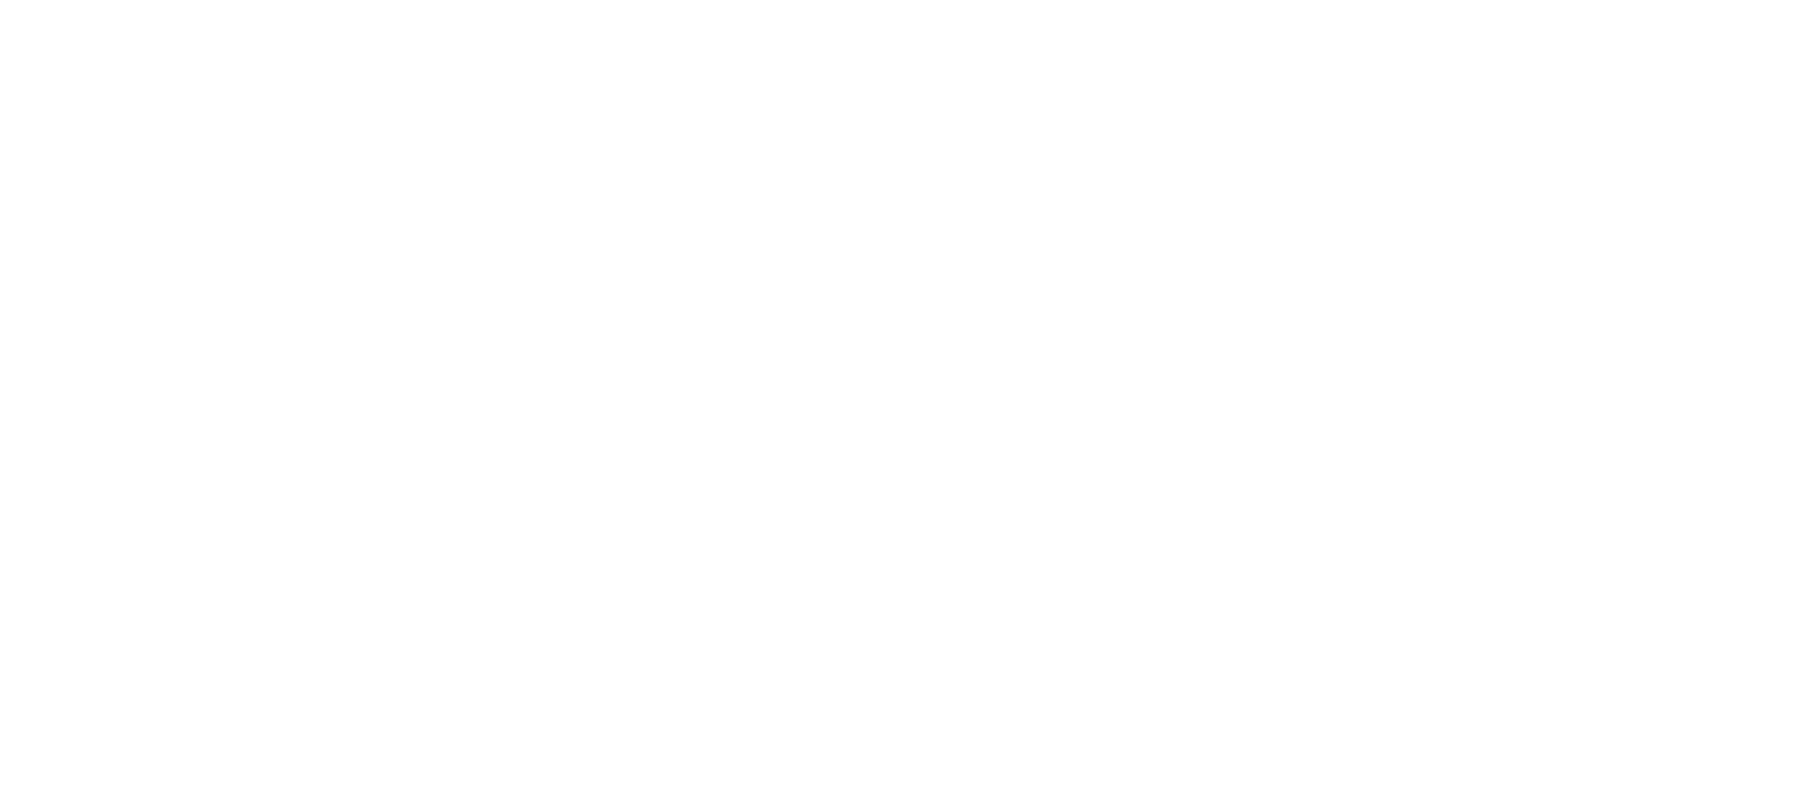

In [23]:
behaviour.plot_wheel_resp()

In [24]:
#spikes = SpikeAnalysis(session, folder, gambl_side)
#spikes.trials_df.loc[0:6, 'select'] = False
#spikes.trials_df.loc[215:, 'select'] = False
#qgrid.show_grid(spikes.trials_df)

In [25]:
add_session(session, gambl_side, sync_obj, missing_rows_ttl, trials, behavior, None)

## JG14_190626

In [26]:
session = 'JG14_190626'

# load calss and set folder depending on platform
if platform.system() == 'Linux':
    # Linux
    folder = linux_folder + '/' + session
elif platform.system() == 'Windows':
    # windows
    folder = windows_folder + r"/" + session
elif platform.system() == 'Darwin':
    folder = mac_folder + r"/" + session

In [ ]:
sync_obj = SyncPhenosys(session, folder, 7, 1)  
missing_rows_ttl = [1428, 1824, 1838, 2861, 2910, 3089, 3245, 3430, 3443]
missing_rows_csv = []
combined = sync_obj.combine_dataframes(missing_rows_ttl, missing_rows_csv, 'channel 1', sync_obj.csv, False)

gambl_side = sync_obj.gambl_side

qgrid.show_grid(combined)

In [ ]:
trials = sync_obj.get_trials(combined)
qgrid.show_grid(trials)

In [ ]:
sync_obj.ttl_info_channel

In [ ]:
plt.figure()
combined['Delta (TTL-CSV)'].plot()
plt.show()

---

In [ ]:
 behaviour = BehaviorAnalysis(session, folder, combined)


In [ ]:
behaviour.plot_wheel_resp()

In [ ]:
#spikes = SpikeAnalysis(session, folder, gambl_side)
#spikes.trials_df.loc[0:6, 'select'] = False
#spikes.trials_df.loc[215:, 'select'] = False
#qgrid.show_grid(spikes.trials_df)

In [ ]:
add_session(session, gambl_side, sync_obj, missing_rows_ttl, trials, behavior, None)

## JG15_190722

In [ ]:
session = 'JG15_190722'

# load calss and set folder depending on platform
if platform.system() == 'Linux':
    # Linux
    folder = linux_folder + '/' + session
elif platform.system() == 'Windows':
    # windows
    folder = windows_folder + r"/" + session
elif platform.system() == 'Darwin':
    folder = mac_folder + r"/" + session

In [ ]:
sync_obj = SyncPhenosys(session, folder, 7, 1)  
missing_rows_ttl = [2094, 2574, 2637, 2808, 2831, 3499]
missing_rows_csv = []
combined = sync_obj.combine_dataframes(missing_rows_ttl, missing_rows_csv, 'channel 1', sync_obj.csv, False)

gambl_side = sync_obj.gambl_side

qgrid.show_grid(combined)

In [ ]:
trials = sync_obj.get_trials(combined)
qgrid.show_grid(trials)

In [ ]:
sync_obj.ttl_info_channel

In [ ]:
plt.figure()
combined['Delta (TTL-CSV)'].plot()
plt.show()

---

In [ ]:
 behaviour = BehaviorAnalysis(session, folder, combined)


In [ ]:
behaviour.plot_wheel_resp()

In [ ]:
#spikes = SpikeAnalysis(session, folder, gambl_side)
#spikes.trials_df.loc[0:6, 'select'] = False
#spikes.trials_df.loc[215:, 'select'] = False
#qgrid.show_grid(spikes.trials_df)

In [ ]:
add_session(session, gambl_side, sync_obj, missing_rows_ttl, trials, behavior, None)

## JG15_190725

In [ ]:
session = 'JG15_190725'

# load calss and set folder depending on platform
if platform.system() == 'Linux':
    # Linux
    folder = linux_folder + '/' + session
elif platform.system() == 'Windows':
    # windows
    folder = windows_folder + r"/" + session
elif platform.system() == 'Darwin':
    folder = mac_folder + r"/" + session

In [ ]:
sync_obj = SyncPhenosys(session, folder, 7, 1)  
missing_rows_ttl = [366,711,1487,1578,1659,2221,2666,2720,2769,2847,3371,3476]
missing_rows_csv = []
combined = sync_obj.combine_dataframes(missing_rows_ttl, missing_rows_csv, 'channel 1', sync_obj.csv, False)

gambl_side = sync_obj.gambl_side

qgrid.show_grid(combined)

In [ ]:
trials = sync_obj.get_trials(combined)
qgrid.show_grid(trials)

In [ ]:
sync_obj.ttl_info_channel

In [ ]:
plt.figure()
combined['Delta (TTL-CSV)'].plot()
plt.show()

---

In [ ]:
 behaviour = BehaviorAnalysis(session, folder, combined)


In [ ]:
behaviour.plot_wheel_resp()

In [ ]:
#spikes = SpikeAnalysis(session, folder, gambl_side)
#spikes.trials_df.loc[0:6, 'select'] = False
#spikes.trials_df.loc[215:, 'select'] = False
#qgrid.show_grid(spikes.trials_df)

In [ ]:
add_session(session, gambl_side, sync_obj, missing_rows_ttl, trials, behavior, None)

## JG18a_190814

In [ ]:
session = 'JG18a_190814'

# load calss and set folder depending on platform
if platform.system() == 'Linux':
    # Linux
    folder = linux_folder + '/' + session
elif platform.system() == 'Windows':
    # windows
    folder = windows_folder + r"/" + session
elif platform.system() == 'Darwin':
    folder = mac_folder + r"/" + session

In [ ]:
sync_obj = SyncPhenosys(session, folder, 7, 1)  
missing_rows_ttl = [405,2621,2693,2770,2959,3015,3029,3038,3048]  #401
missing_rows_csv = []
combined = sync_obj.combine_dataframes(missing_rows_ttl, missing_rows_csv, 'channel 1', sync_obj.csv, False)

gambl_side = sync_obj.gambl_side

qgrid.show_grid(combined)

In [ ]:
trials = sync_obj.get_trials(combined)
qgrid.show_grid(trials)

In [ ]:
sync_obj.ttl_info_channel

In [ ]:
plt.figure()
combined['Delta (TTL-CSV)'].plot()
plt.show()

---

In [ ]:
 behaviour = BehaviorAnalysis(session, folder, combined)


In [ ]:
behaviour.plot_wheel_resp()

In [ ]:
#spikes = SpikeAnalysis(session, folder, gambl_side)
#spikes.trials_df.loc[0:6, 'select'] = False
#spikes.trials_df.loc[215:, 'select'] = False
#qgrid.show_grid(spikes.trials_df)

In [ ]:
add_session(session, gambl_side, sync_obj, missing_rows_ttl, trials, behavior, None)

## JG18b_190828

In [ ]:
session = 'JG18b_190828'

# load calss and set folder depending on platform
if platform.system() == 'Linux':
    # Linux
    folder = linux_folder + '/' + session
elif platform.system() == 'Windows':
    # windows
    folder = windows_folder + r"/" + session
elif platform.system() == 'Darwin':
    folder = mac_folder + r"/" + session

In [ ]:
sync_obj = SyncPhenosys(session, folder, 7, 1)  
missing_rows_ttl = [1744, 2363, 2648, 2701, 2731, 2778,2953,2967]
missing_rows_csv = []
combined = sync_obj.combine_dataframes(missing_rows_ttl, missing_rows_csv, 'channel 1', sync_obj.csv, False)

gambl_side = sync_obj.gambl_side


qgrid.show_grid(combined)

In [ ]:
gambl_side

In [ ]:
trials = sync_obj.get_trials(combined)
qgrid.show_grid(trials)

In [ ]:
sync_obj.ttl_info_channel

In [ ]:
plt.figure()
combined['Delta (TTL-CSV)'].plot()
plt.show()

---

In [ ]:
 behaviour = BehaviorAnalysis(session, folder, combined)


In [ ]:
behaviour.plot_wheel_resp()

In [ ]:
spikes = SpikeAnalysis(session, folder, gambl_side)
spikes.trials_df.loc[0:6, 'select'] = False
spikes.trials_df.loc[215:, 'select'] = False
qgrid.show_grid(spikes.trials_df)

In [ ]:
add_session(session, gambl_side, sync_obj, missing_rows_ttl, trials, behavior, spikes)

# Behaviour Analysis

In [65]:


def convert_numeric(columns, df):
    for column in columns:
        df[column] = pd.to_numeric(df[column])
    return df

def get_trial_info(all_sessions_dict):
    session_info_df = pd.DataFrame(columns=['Session','Gambl Side','prop bins', 
                                       'Trials', 'tot. Trials','wheel ns','no resp',
                                       'right chosen', 'right rewarded',
                                       'left chosen', 'left rewarded',
                                      ])
    
    for key in all_sessions_dict.keys():
        session_dict = all_sessions_dict[key]
        session=session_dict['session']
        gambl_side=session_dict['gambl_side']
        #sync_obj=session_dict['sync_obj']
        missing_rows_ttl=session_dict['missing_rows_ttl']
        missing_rows_ttl = missing_rows_ttl[0]
        combined=session_dict['combined']
        #combined = combined[0]
        trials=session_dict['trials']
        #trials=trials[0]
        behavior=session_dict['behavior']
        #behavior=behavior[0]
        #spikes=session_dict['spikes']
        
        prop_bin=list((combined['CSV Probability']).dropna().unique())
        # get info form combined
        all_trials = int(combined.index.get_level_values(0).max())
        good_trials = int(combined.index.get_level_values(1).max())
        wheel_ns = all_trials - good_trials
        
        no_resp = (combined['CSV Event']=='no response in time').sum(axis=0)
        right_ch = (combined['CSV Event']=='right_norw').sum(axis=0) + (combined['CSV Event']=='right_rw').sum(axis=0)
        right_rw = (combined['CSV Event']=='right_rw').sum(axis=0)
        left_ch = (combined['CSV Event']=='left_norw').sum(axis=0) + (combined['CSV Event']=='left_rw').sum(axis=0)
        left_rw = (combined['CSV Event']=='left_rw').sum(axis=0)
        
        session_info_df.loc[session_info_df.shape[0] + 1] = [session,gambl_side,prop_bin,
                                                             good_trials,all_trials,wheel_ns,no_resp,
                                                             right_ch,right_rw,
                                                             left_ch,left_rw]
        
        session_info_df = convert_numeric(['Trials', 'tot. Trials','wheel ns','no resp','right chosen', 
                         'right rewarded','left chosen', 'left rewarded'],
                       session_info_df)
        
    return session_info_df

In [127]:
def boxplot(df,columns,scatter=True,title=None):
    plt.figure()
    session_info_df.boxplot(column=columns,return_type='axes')
    
    if scatter:
        i = 1
        for column in columns:
            y=session_info_df[column] 
            x=np.ones(y.shape[0])*i
            plt.plot(x, y, 'r.', alpha=0.5)
            i+=1

    plt.ylabel('Trial')
    plt.title(title)

    plt.show()

In [66]:
#all_sessions_dict = load_all_sessions_dict_pickl()

session_info_df = get_trial_info(all_sessions_dict)
session_info_df

,Session,Gambl Side,prop bins,Trials,tot. Trials,wheel ns,no resp,right chosen,right rewarded,left chosen,left rewarded
1,JG14_190621,right,"[0.75, 0.25, 0.125]",266,569,303,26,101,42,140,126
2,JG14_190619,right,"[0.125, 0.25, 0.75]",278,1143,865,9,94,57,176,159
3,JG14_190626,right,"[0.125, 0.25, 0.75]",358,1297,939,43,111,63,205,185
4,JG15_190722,left,"[0.125, 0.25, 0.75]",438,936,498,58,248,223,133,82
5,JG15_190725,right,"[0.75, 0.25, 0.125]",472,899,427,76,139,64,258,232
6,JG18a_190814,left,"[0.125, 0.25, 0.75]",399,649,250,29,188,169,183,114
7,JG18b_190828,right,"[0.75, 0.25, 0.125]",374,726,352,33,109,43,233,209


<IPython.core.display.Javascript object>


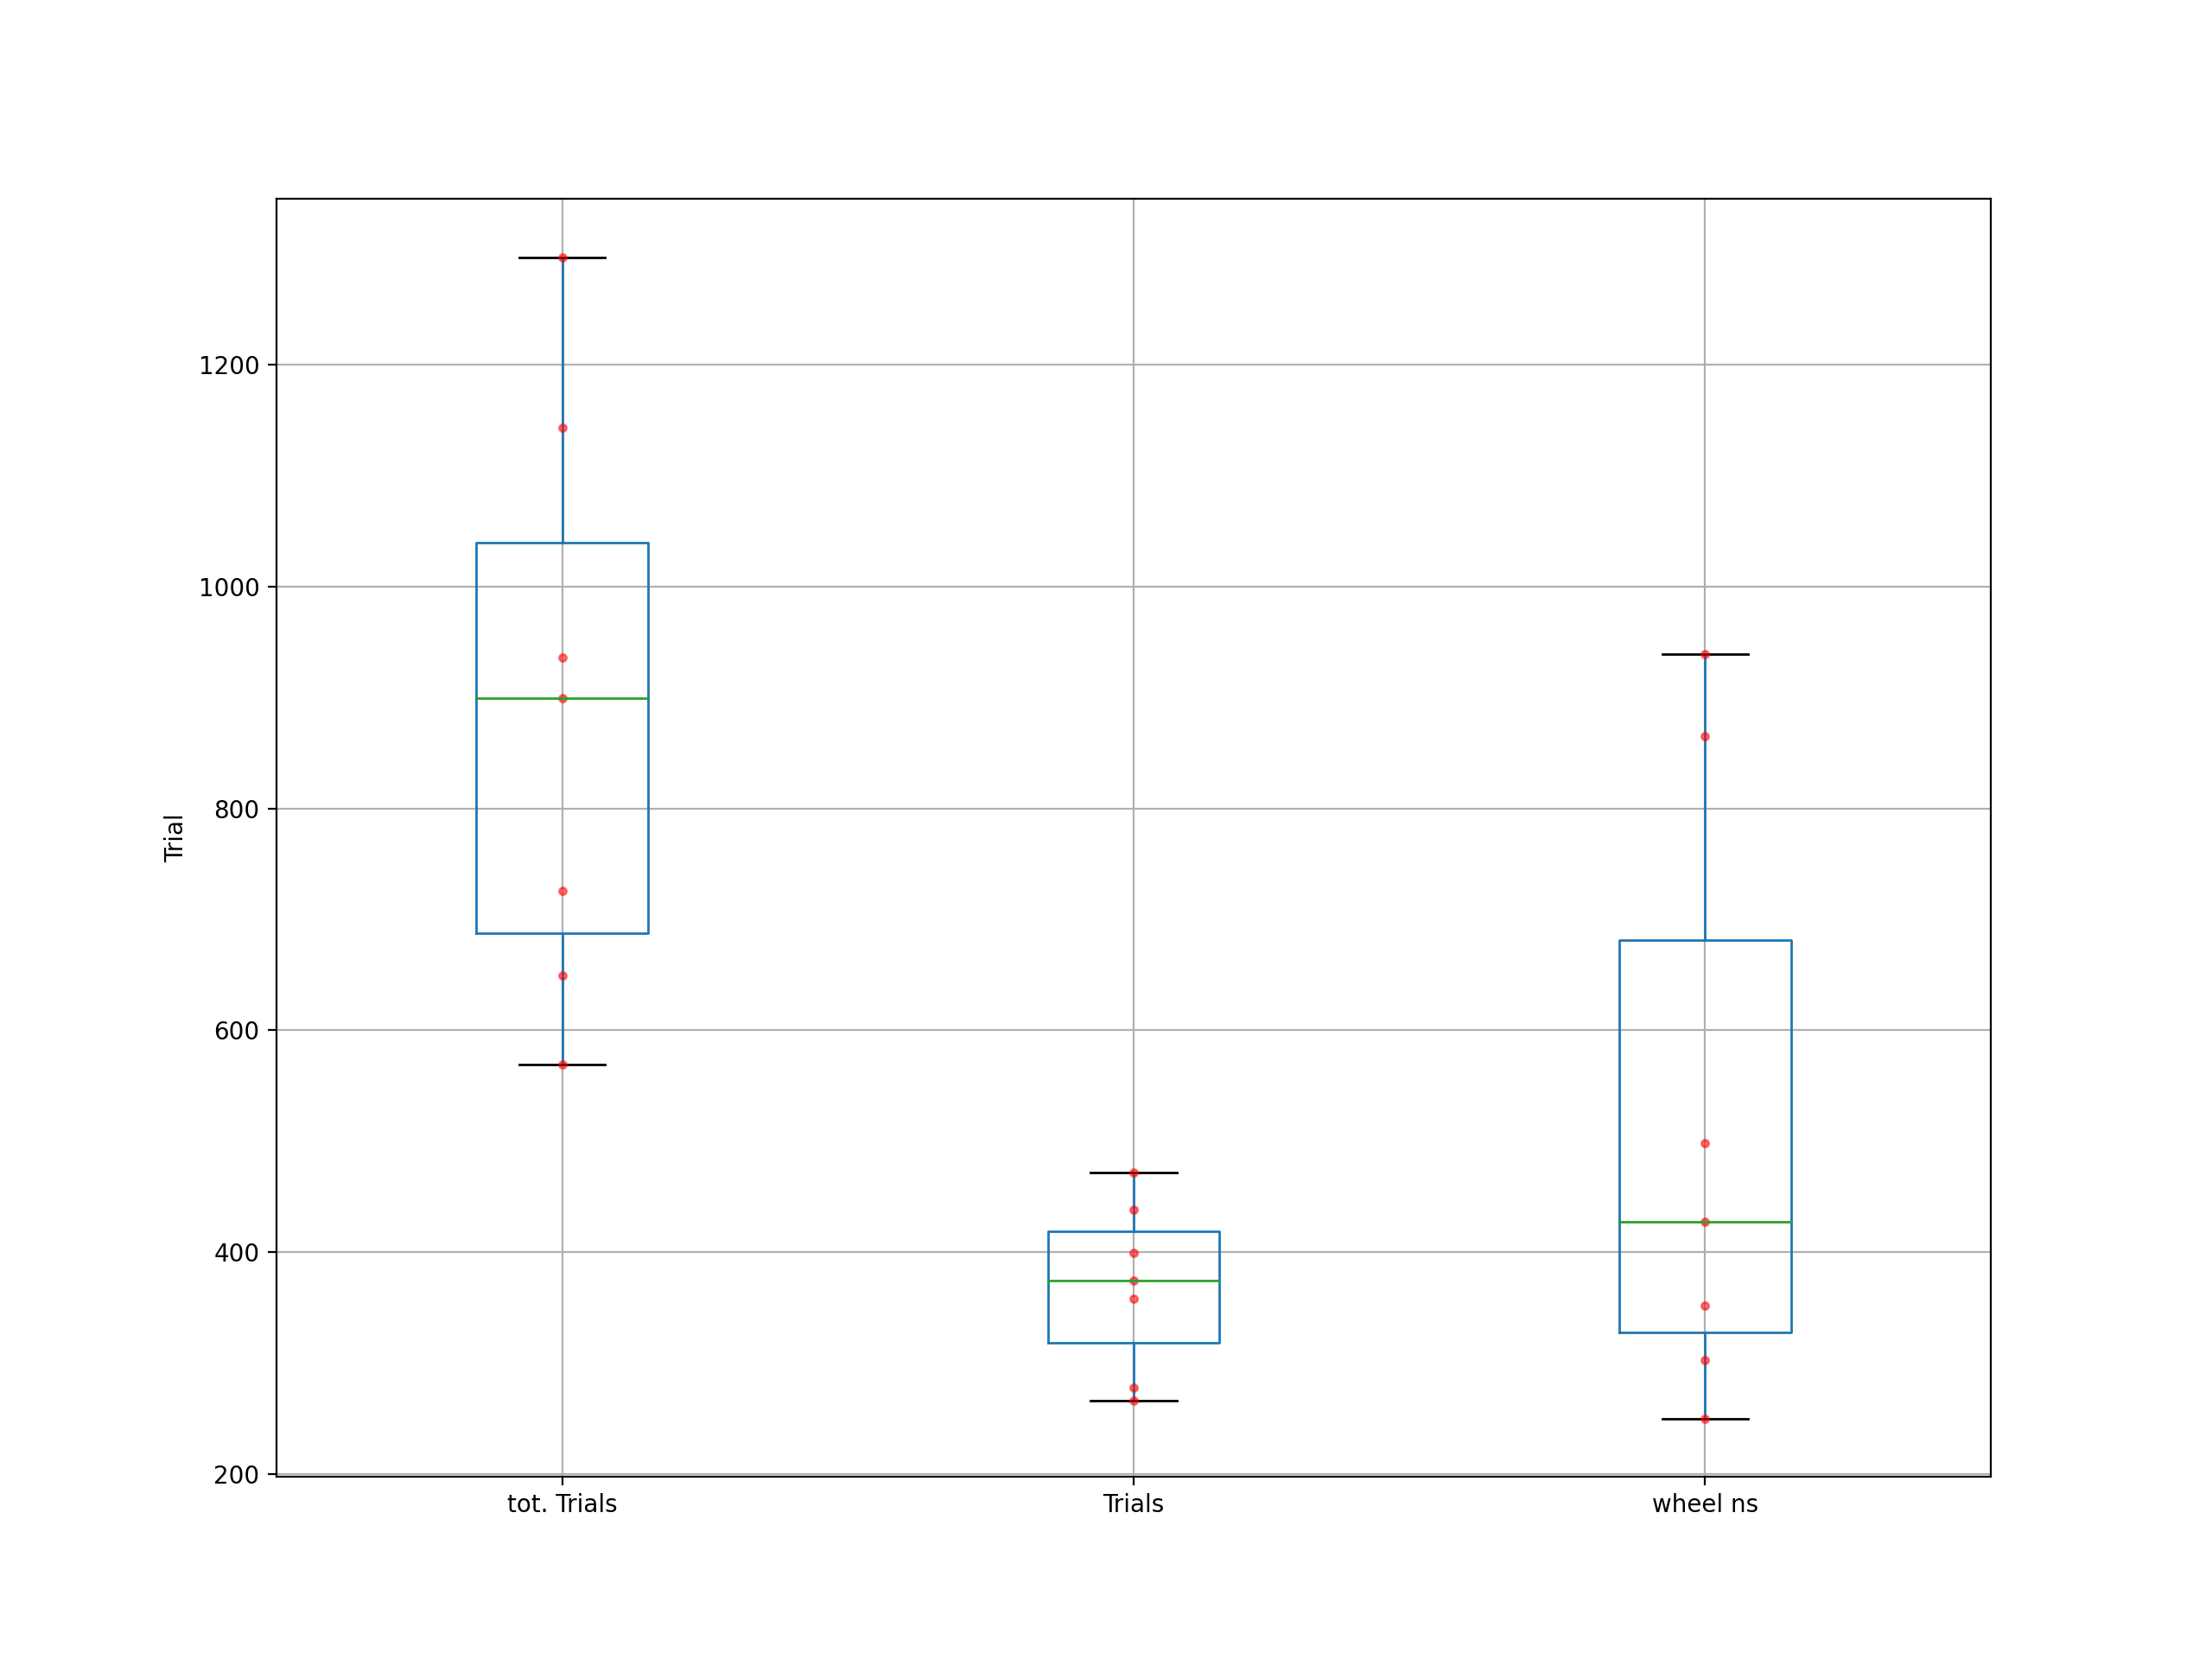

In [128]:
boxplot(session_info_df,['tot. Trials', 'Trials','wheel ns'],True)

<IPython.core.display.Javascript object>


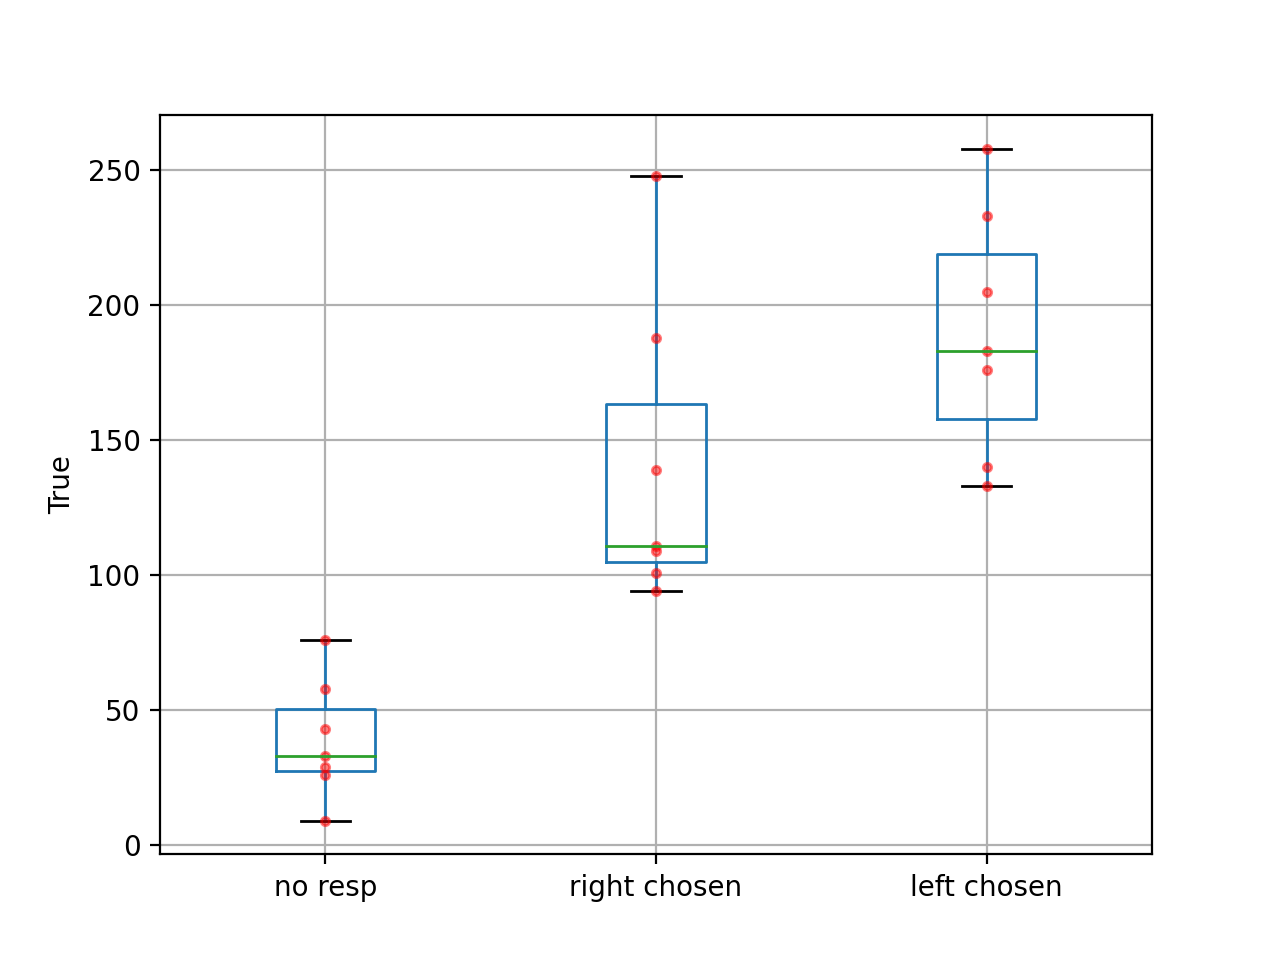

In [101]:
boxplot(session_info_df,['no resp','right chosen','left chosen'],True)

<IPython.core.display.Javascript object>


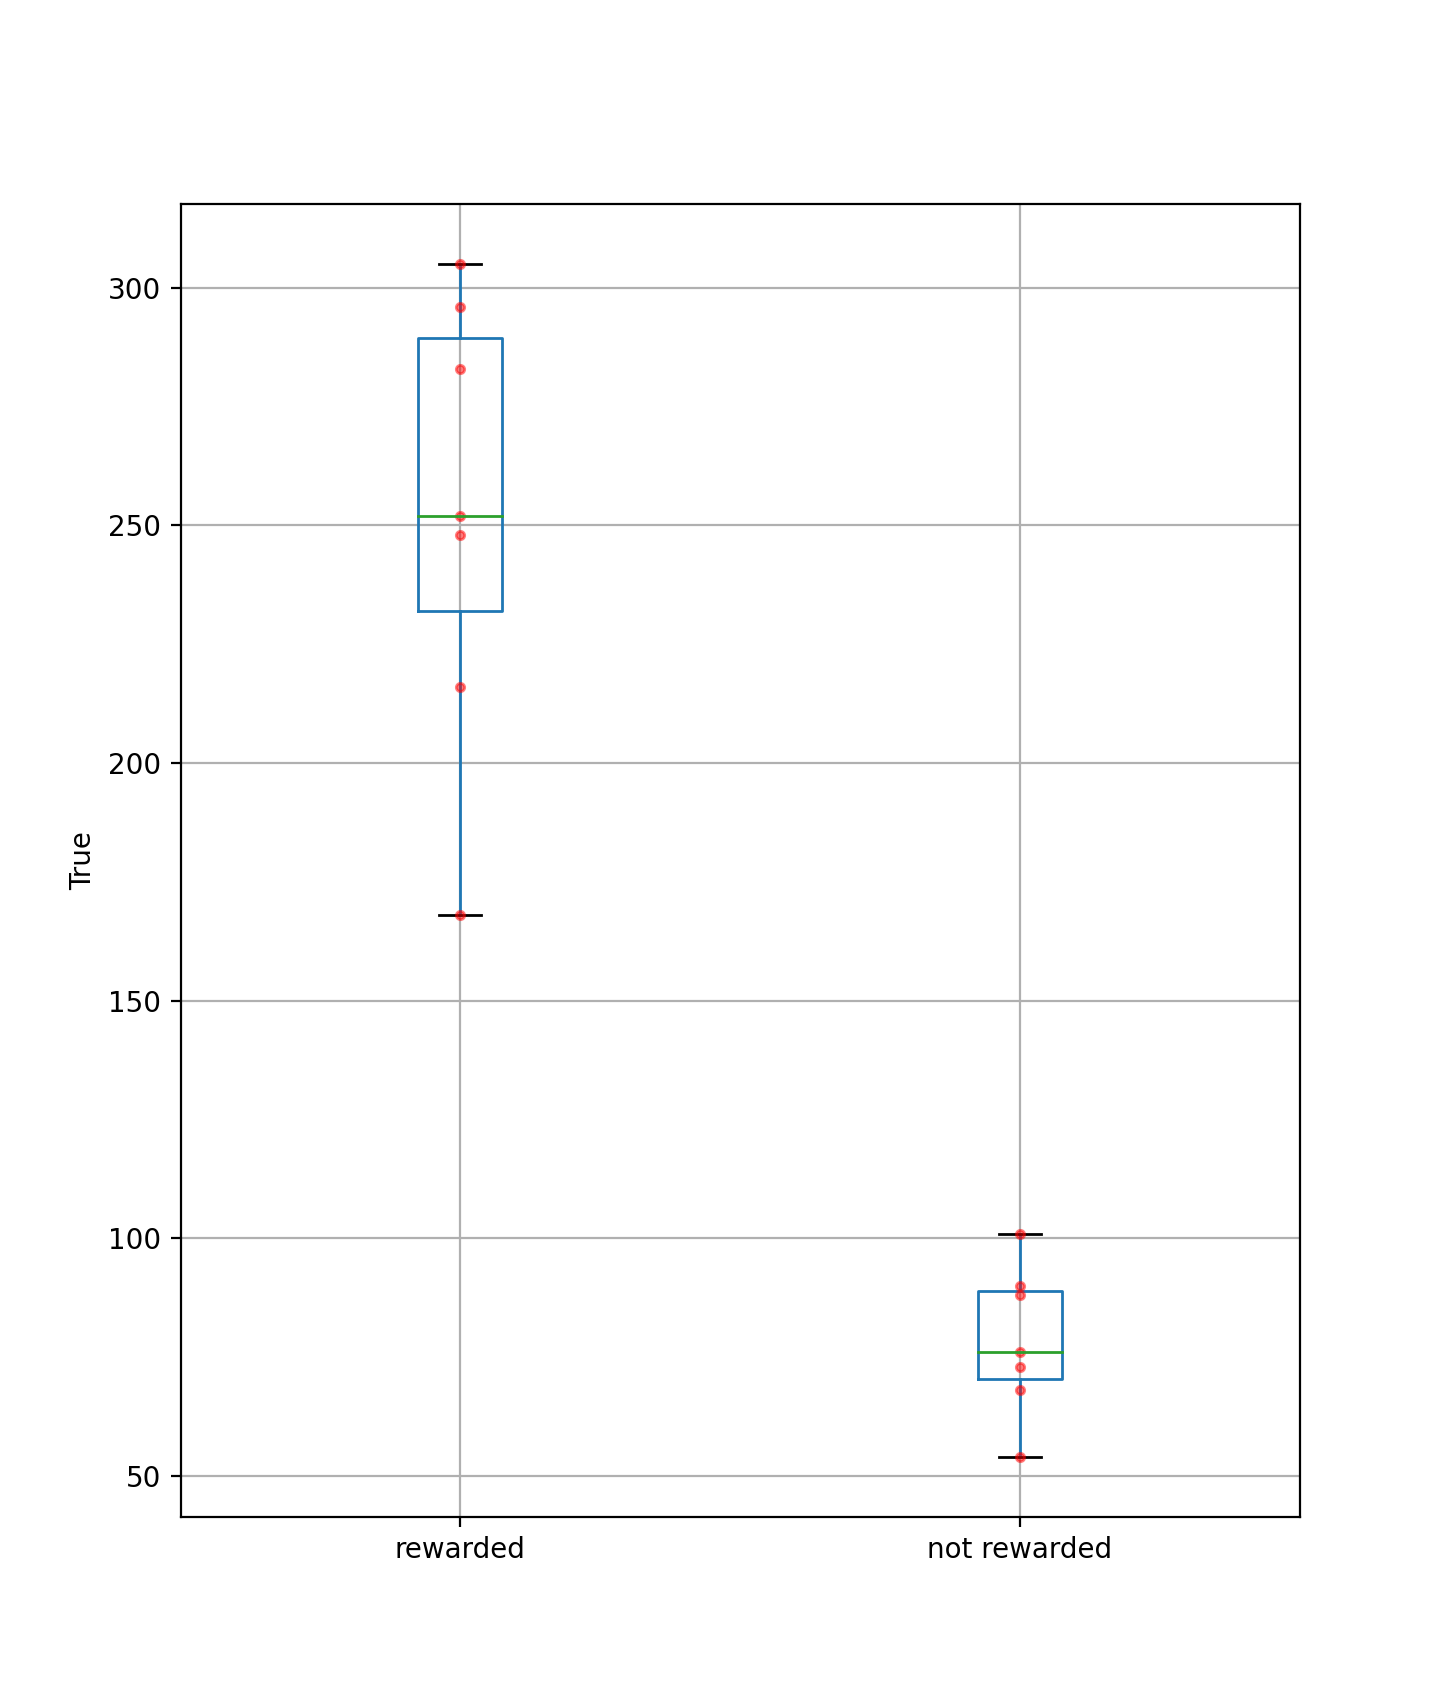

In [122]:
session_info_df['chosen'] = (session_info_df['right chosen'] + session_info_df['left chosen'])
session_info_df['rewarded'] = (session_info_df['right rewarded']+session_info_df['left rewarded'])
session_info_df['not rewarded'] = (session_info_df['chosen'] - session_info_df['rewarded'])

boxplot(session_info_df,['rewarded','not rewarded'],True)

<IPython.core.display.Javascript object>


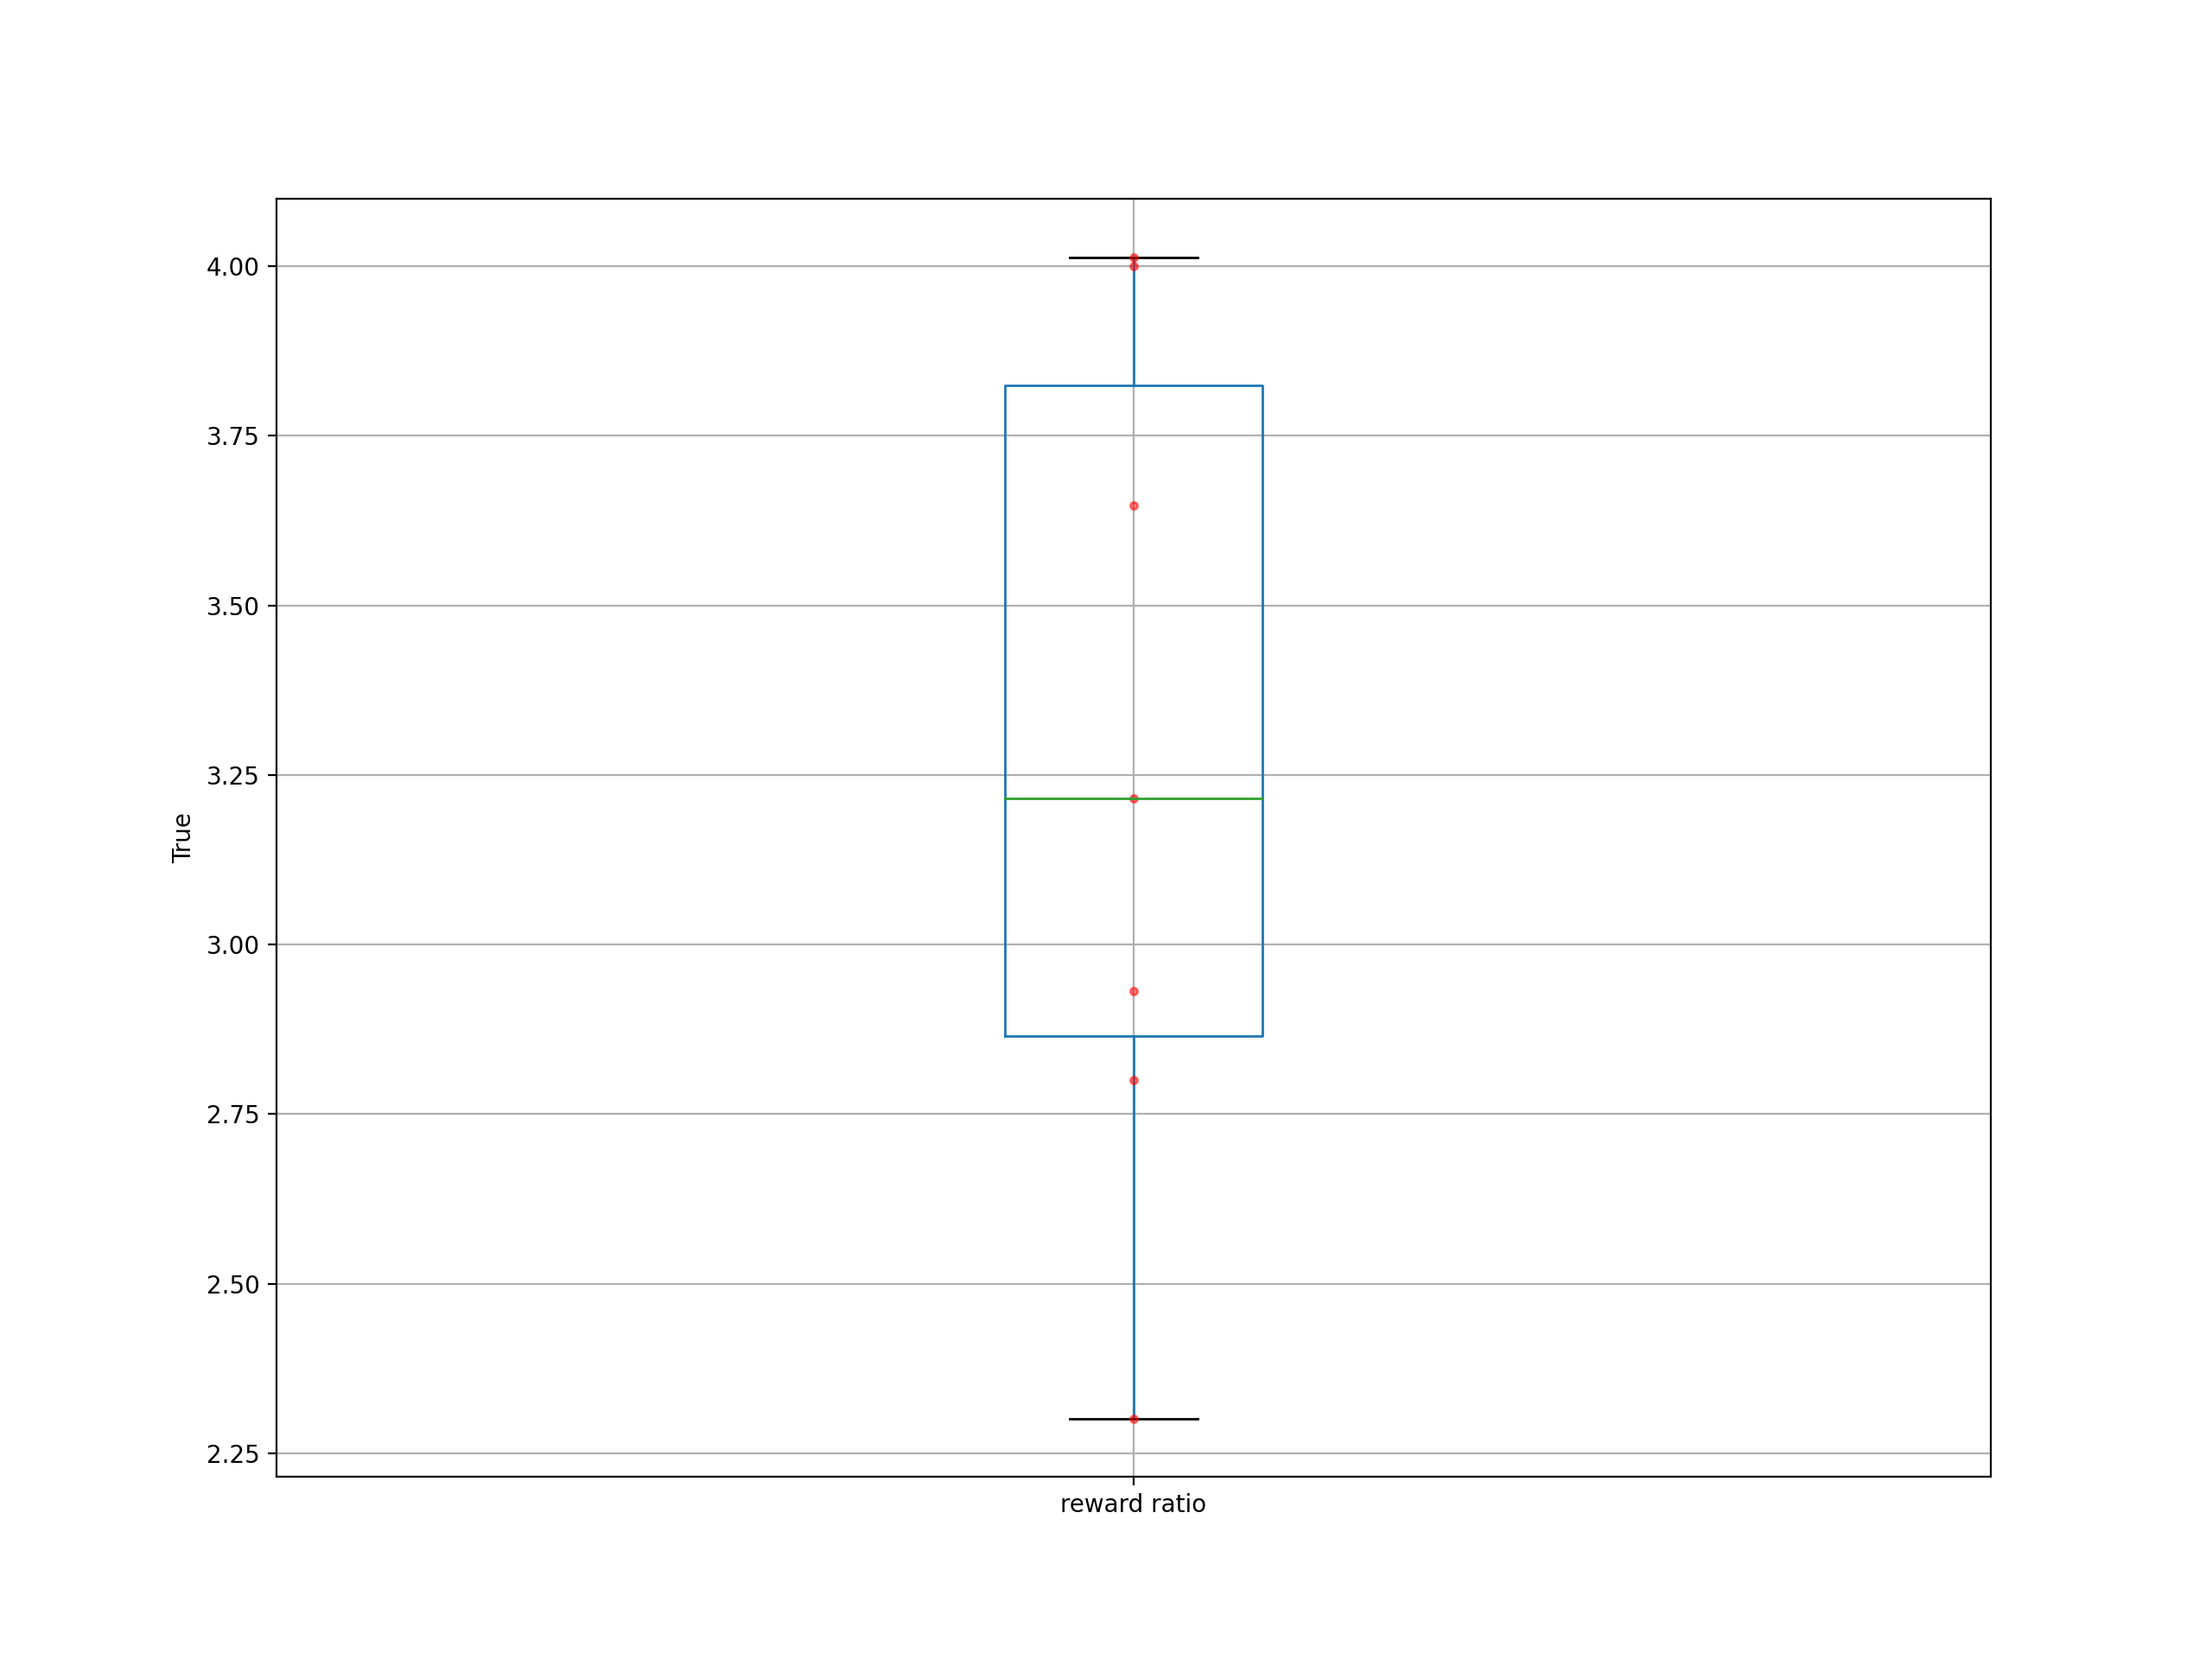

In [125]:
session_info_df['reward ratio'] = (session_info_df['rewarded'] / session_info_df['not rewarded'])
boxplot(session_info_df,['reward ratio'],True)

In [112]:

ratio = (session_info_df['rewarded'] / session_info_df['not rewarded'])
ratio = ratio/(ratio.max()-ratio.min())
ratio_norm = (ratio-ratio.mean())/ratio.std()
ratio_norm
#session_info_df['rewarded ratio'] = (session_info_df['chosen'] - session_info_df['rewarded'])


#boxplot(session_info_df,['rewarded ratio'],True)

1   -1.503266
2    1.125871
3    0.579589
4    1.146237
5   -0.529200
6   -0.087744
7   -0.731487
dtype: float64

In [110]:
ratio/(ratio.max()-ratio.min())

1    1.344425
2    2.336738
3    2.130555
4    2.344425
5    1.712065
6    1.878684
7    1.635717
dtype: float64

In [111]:
ratio.max()-ratio.min()

1.711788031723144

<IPython.core.display.Javascript object>


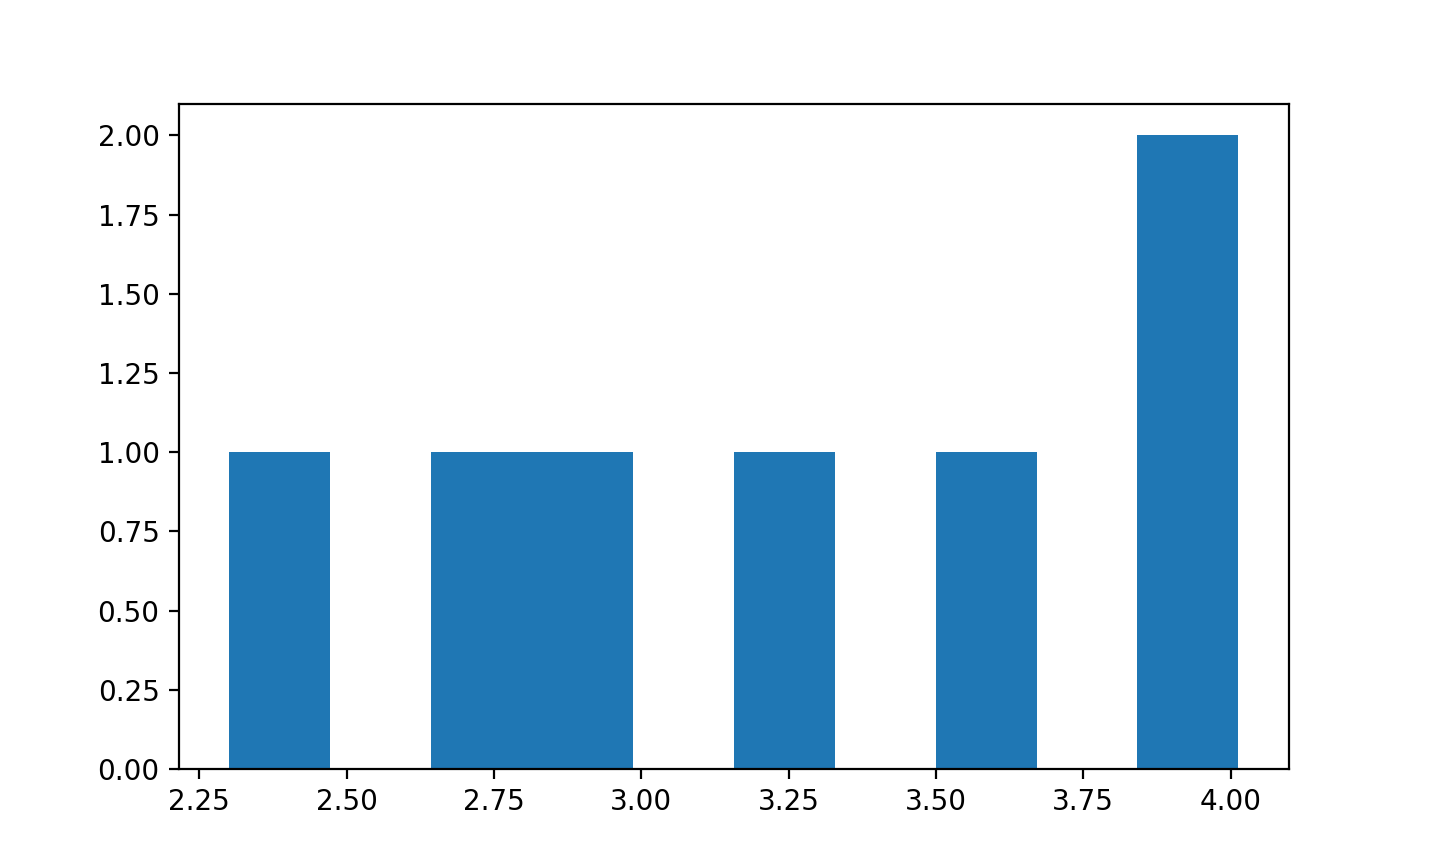

(array([1., 0., 1., 1., 0., 1., 0., 1., 0., 2.]),
 array([2.30136986, 2.47254867, 2.64372747, 2.81490627, 2.98608508,
        3.15726388, 3.32844268, 3.49962149, 3.67080029, 3.84197909,
        4.01315789]),
 <BarContainer object of 10 artists>)

In [121]:
ratio = (session_info_df['rewarded'] / session_info_df['not rewarded'])

plt.figure()
plt.hist(ratio)

# Spike Analysis

In [60]:


session, gambl_side, sync_obj, combined, trials_df, behavior, spikes = load_session('JG18b_190828', [1744, 2363, 2648, 2701, 2731, 2778,2953,2967],True,[])

In [365]:

session, gambl_side, sync_obj, behavior_obj, spikes_obj = load_session('JG14_190621', [1900,1931,1996,2058,2127],True,[(0,6),(215,'end')])


/opt/anaconda3/envs/spikes/lib/python3.8/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


In [7]:
session = 'JG14_190621'
folder = mac_folder + r"/" + session
rows_missing_ttl = [1900,1931,1996,2058,2127]
deselect_trials = [(0,6),(215,'end')]



In [84]:
sync_obj = SyncPhenosys(session, folder, 7, 1, rows_missing_ttl) 


/opt/anaconda3/envs/spikes/lib/python3.8/site-packages/IPython/extensions/autoreload.py:245: PerformanceWarning: indexing past lexsort depth may impact performance.
  superreload(m, reload, self.old_objects)
/opt/anaconda3/envs/spikes/lib/python3.8/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


In [85]:
qgrid.show_grid(sync_obj.combined_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [86]:
qgrid.show_grid(sync_obj.trials_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [87]:
qgrid.show_grid(sync_obj.good_trials_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [88]:
behavior_obj = BehaviorAnalysis(sync_obj, deselect_trials)

/opt/anaconda3/envs/spikes/lib/python3.8/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [90]:
qgrid.show_grid(behavior_obj.good_trials_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [93]:
behavior_obj.good_trials_df.loc[0:6,'select']=False

/opt/anaconda3/envs/spikes/lib/python3.8/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [91]:
qgrid.show_grid(behavior_obj.trials_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [ ]:
spikes_obj = SpikeAnalysis(behavior_obj)

In [77]:
qgrid.show_grid(spikes_obj.trials_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [ ]:
qgrid.show_grid(spikes_obj.trials_df)

In [71]:
behavior_obj.trials_df.loc[[behavior_obj.trials_df['good'] and [behavior_obj.trials_df['index_good_trials'],:]

,index_good_trials,start,cue,sound,openloop,reward,iti,end,event,probability,length,select,right,left,reward_given,good
index_all_trials,,,,,,,,,,,,,,,,
0,0,184261,204966,205627,206346,346501,346782,347017,no response in time,0.750,162756,False,False,False,False,True
1,1,347296,367357,367997,368675,469942,488083,508307,right_rw,0.750,161011,False,True,False,True,True
2,2,508590,528631,529285,529965,540668,558808,579008,right_rw,0.750,70418,False,True,False,True,True
3,3,579268,599314,599969,600650,613871,614030,634233,right_norw,0.750,54965,False,True,False,False,True
16,4,751059,771123,771761,772445,780009,783821,804022,left_rw,0.750,52963,True,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,262,21715394,21735452,21736093,21736773,21876901,21877101,21877324,no response in time,0.125,161930,False,False,False,False,True
566,263,21877585,21897643,21898282,21898964,22033712,22037470,22057672,left_rw,0.125,180087,False,False,True,True,True
567,264,22057937,22077977,22078634,22079315,22103174,22103335,22123538,right_norw,0.125,65601,False,True,False,False,True


In [73]:
good_trials = behavior_obj.trials_df.loc[behavior_obj.trials_df['good'],:]
good_trials.set_index('index_good_trials',inplace=True)
good_trials

,start,cue,sound,openloop,reward,iti,end,event,probability,length,select,right,left,reward_given,good
index_good_trials,,,,,,,,,,,,,,,
0,184261,204966,205627,206346,346501,346782,347017,no response in time,0.750,162756,False,False,False,False,True
1,347296,367357,367997,368675,469942,488083,508307,right_rw,0.750,161011,False,True,False,True,True
2,508590,528631,529285,529965,540668,558808,579008,right_rw,0.750,70418,False,True,False,True,True
3,579268,599314,599969,600650,613871,614030,634233,right_norw,0.750,54965,False,True,False,False,True
4,751059,771123,771761,772445,780009,783821,804022,left_rw,0.750,52963,True,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,21715394,21735452,21736093,21736773,21876901,21877101,21877324,no response in time,0.125,161930,False,False,False,False,True
263,21877585,21897643,21898282,21898964,22033712,22037470,22057672,left_rw,0.125,180087,False,False,True,True,True
264,22057937,22077977,22078634,22079315,22103174,22103335,22123538,right_norw,0.125,65601,False,True,False,False,True


In [81]:
spikes_obj.plt_trial_hist_and_fit(spikes_obj.good_trials_df.loc[spikes_obj.good_trials_df['select'], 'length'])

AttributeError: 'SpikeAnalysis' object has no attribute 'good_trials_df'

In [63]:
spikes.trials_df.loc[spikes.trials_df['select'],:]

,start,cue,sound,openl,reward,iti,end,event,length_ms,length,select
trial,,,,,,,,,,,
1,334072,354448,355107,355807,461734,461893,482117,6,7402.25,148045,True
2,482395,502436,503096,503777,518580,522377,542601,7,3010.30,60206,True
3,542880,563038,563679,564362,568181,571940,592143,7,2463.15,49263,True
4,625246,645284,645924,646605,652566,670708,690909,5,3283.15,65663,True
5,739190,759271,759911,760593,766554,770333,790533,7,2567.15,51343,True
...,...,...,...,...,...,...,...,...,...,...,...
371,31466222,31486262,31486919,31487599,31627707,31627907,31628169,0,8097.35,161947,True
372,31628169,31629407,31649457,31650109,31650788,31790898,31791317,4,8157.40,163148,True
373,31791579,31811638,31812279,31812958,31953067,31953267,31953487,0,8095.40,161908,True


In [78]:
folder

'/Users/max/Google Drive/3 Projekte/Masterarbeit Laborarbeit Neuroscience/1 Data Analysis/JG14_190621'

In [79]:

excel_df = pd.read_excel(folder+"/output_file.xlsx", 'Daten', header=[0, 1] )

In [80]:
            


# clean up trials data Frame
# drop NaN from loaded excel
excel_df.dropna(axis=0, how='all', inplace=True)
# drop 0 leading rows from loaded excel
excel_df = excel_df.loc[(excel_df.iloc[:,[1,2,3,4,5,6,7,8]]!=0).sum(axis=1)==8, :]
# create cleaned up data frame with each trial in one row and times and behavior
trials_df = excel_df.loc[:]['TTL']
# set trials ans index and name as trials
trials_df = trials_df.set_index('trial-num')
trials_df.index.name = 'trial'
# rename colums to aprop names
trials_df = trials_df.rename(columns={'reward':'event','time 1':'start', 'time 2':'cue', 'time 3':'sound','time 4':'openl','time reward':'reward','time inter trial in.':'iti','time inter trial end':'end', 'time dif trial':'length_ms', 'ttl start rel':'rel'})
# drop all unnecessary colums
trials_df = trials_df.drop(['dif ttl - excel', 'diff round', 'excel start rel', 'start rel dif', 'TIstarts','IND-CUE_pres_start','SOUND_start', 'resp-time-window_start', 'ITIstarts','ITIends', 'time dif trial round', 'rel'], axis = 1 )
# drop al rows with only 0
trials_df = trials_df.drop(trials_df[trials_df['start']==0].index, axis=0)
# convert times in ms to count 20k per second (*20)
trials_df.loc[:,'start':'end']*=20
# convert all time columns to int64
trials_df = trials_df.astype({'start': int, 'cue': int, 'sound': int, 'openl': int, 'reward': int, 'iti': int, 'end': int})
# calculate trial length in clicks
trials_df['length']=trials_df['end']-trials_df['start']
trials_df['select']=np.full((trials_df.shape[0] ,1), True ,dtype='bool')



In [81]:
excel_df

Excel                                                      \
    trial-num       time 1       time 2       time 3       time 4   
0         1.0      814.001     1852.002     1883.996     1919.999   
1         2.0     8966.999     9969.999    10002.995    10037.002   
2         3.0    17031.998    18034.999    18067.001    18100.999   
3         4.0    20566.000    21569.000    21601.003    21635.001   
4         5.0    29154.998    30157.999    30190.001    30225.002   
..        ...          ...          ...          ...          ...   
254     263.0  1077343.002  1078346.002  1078377.996  1078412.997   
255     264.0  1085452.998  1086454.996  1086486.999  1086521.999   
256     265.0  1094469.996  1095472.003  1095504.999  1095538.998   
257     266.0  1097763.002  1098766.003  1098798.999  1098832.998   
258     267.0  1106003.999  1107008.001  1107039.995  1107074.002   

                                                                     \
     time reward time inter trial in. time inter trial end TIstarts   
0       8927.998             8941.001             8953.995      1.0   
1      15098.997            16007.000            17018.001      1.0   
2      18636.999            19542.998            20552.997      1.0   
3      22295.996            22303.997            23313.995      1.0   
4      30603.001            30792.995            31803.996      1.0   
..           ...                  ...                  ...      ...   
254  1085417.998          1085428.003          1085439.001      1.0   
255  1093258.003          1093446.001          1094457.002      1.0   
256  1096730.998          1096738.999          1097749.999      1.0   
257  1104972.996          1104980.997          1105990.995      1.0   
258  1114079.003          1114088.999          1114099.998      1.0   

                                                                            \
    IND-CUE_pres_start SOUND_start resp-time-window_start reward ITIstarts   
0                  2.0         3.0                    4.0    9.0      10.0   
1                  2.0         3.0                    4.0    5.0      10.0   
2                  2.0         3.0                    4.0    5.0      10.0   
3                  2.0         3.0                    4.0    6.0      10.0   
4                  2.0         3.0                    4.0    7.0      10.0   
..                 ...         ...                    ...    ...       ...   
254                2.0         3.0                    4.0    9.0      10.0   
255                2.0         3.0                    4.0    7.0      10.0   
256                2.0         3.0                    4.0    6.0      10.0   
257                2.0         3.0                    4.0    6.0      10.0   
258                2.0         3.0                    4.0    9.0      10.0   

                                                      TTL              \
    ITIends time dif trial time dif trial round trial-num      time 1   
0      11.0       8139.994               8140.0       1.0     9213.05   
1      11.0       8051.002               8051.0       2.0    17364.80   
2      11.0       3520.999               3521.0       3.0    25429.50   
3      11.0       2747.995               2748.0       4.0    28963.40   
4      11.0       2648.998               2649.0       5.0    37552.95   
..      ...            ...                  ...       ...         ...   
254    11.0       8095.999               8096.0     260.0  1085769.70   
255    11.0       9004.004               9004.0     261.0  1093879.25   
256    11.0       3280.003               3280.0     262.0  1102896.85   
257    11.0       8227.993               8228.0     263.0  1106189.80   
258    11.0       8095.999               8096.0     264.0  1114431.35   

                                                                          \
         time 2      time 3      time 4 time reward time inter trial in.   
0      10248.30    10281.35    10317.30    17325.05             17339

In [92]:
trials_df_old = trials_df
trials_df_old

,start,cue,sound,openl,reward,iti,end,event,length_ms,reward probability,length,select
trial,,,,,,,,,,,,
1.0,184261,204966,205627,206346,346501,346782,347017,0.0,8137.80,0.750,162756,True
2.0,347296,367357,367997,368675,469942,488083,508307,5.0,8050.55,0.750,161011,True
3.0,508590,528631,529285,529965,540668,558808,579008,5.0,3520.90,0.750,70418,True
4.0,579268,599314,599969,600650,613871,614030,634233,6.0,2748.25,0.750,54965,True
5.0,751059,771123,771761,772445,780009,783821,804022,8.0,2648.15,0.750,52963,True
...,...,...,...,...,...,...,...,...,...,...,...,...
260.0,21715394,21735452,21736093,21736773,21876901,21877101,21877324,0.0,8096.50,0.125,161930,True
261.0,21877585,21897643,21898282,21898964,22033712,22037470,22057672,7.0,9004.35,0.125,180087,True
262.0,22057937,22077977,22078634,22079315,22103174,22103335,22123538,6.0,3280.05,0.125,65601,True


In [275]:
qgrid.show_grid(combined)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [273]:
combined = combined_old
combined

TTL Start  TTL Length  \
All Trial Trial index Group Index                           
0.0       0.0   0     0              184261.0        17.0   
                1     1              204966.0        39.0   
                2     2              205627.0        61.0   
                3     3              206346.0        80.0   
                4     4              346501.0       178.0   
...                                       ...         ...   
569.0     266.0 2474  6            22450560.0       216.0   
NaN       NaN   2475  0            22450817.0        21.0   
                2476  1            22470860.0        37.0   
                2477  2            22471517.0        61.0   
                2478  3            22472202.0        76.0   

                                             TTL Event  TTL Start norm  \
All Trial Trial index Group Index                                        
0.0       0.0   0     0                          start             0.0   
                1     1                            cue         20705.0   
                2     2                          sound         21366.0   
                3     3                       openloop         22085.0   
                4     4            no response in time        162240.0   
...                                                ...             ...   
569.0     266.0 2474  6                            end      22266299.0   
NaN       NaN   2475  0                          start      22266556.0   
                2476  1                            cue      22286599.0   
                2477  2                          sound      22287256.0   
                2478  3                       openloop      22287941.0   

                                   TTL index   CSV Start            CSV Event  \
All Trial Trial index Group Index                                               
0.0       0.0   0     0                  0.0     16280.0                start   
                1     1                  1.0     37040.0                  cue   
                2     2                  2.0     37679.0                sound   
                3     3                  3.0     38399.0             openloop   
                4     4                  4.0    178559.0  no response in time   
...                                      ...         ...                  ...   
569.0     266.0 2474  6               2171.0  22281999.0                  end   
NaN       NaN   2475  0               2172.0  22282260.0                start   
                2476  1               2173.0  22302320.0                  cue   
                2477  2               2174.0  22302959.0                sound   
                2478  3               2175.0  22303659.0             openloop   

                                  CSV Probability  CSV Start norm  CSV index  \
All Trial Trial index Group Index                                              
0.0       0.0   0     0                     0.750             0.0        0.0   
                1     1                     0.750         20760.0        1.0   
                2     2                     0.750         21399.0        2.0   
                3     3                     0.750         22119.0        3.0   
                4     4                     0.750        162279.0        4.0   
...                                           ...             ...        ...   
569.0     266.0 2474  6                     0.125      22265719.0     2171.0   
NaN       NaN   2475  0                     0.125      22265980.0     2172.0   
                2476  1                     0.125      22286040.0     2173.0   
                2477  2                     0.125      22286679.0     2174.0   
                2478  3                     0.125      22287379.0     2175.0   

                                   Delta (TTL-CSV) Compare Good Trial  
All Trial Trial index Group Index                                      
0.0       0.0   0     0                 

In [274]:
ttl_norm = combined.loc[pd.IndexSlice[0,:,:,0],'TTL Start'].values[0]-combined.loc[pd.IndexSlice[0,:,:,0],'CSV Start'].values[0]
current_delta = 0
for index, row in combined.iterrows():
    # patch ttl missing values
    if np.isnan(row['TTL Start']):
        combined.loc[index,'TTL Start'] = row['CSV Start']+ttl_norm+current_delta
    else:
        current_delta = row['Delta (TTL-CSV)']

/opt/anaconda3/envs/spikes/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2877: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


In [252]:
row['TTL Start']

22472202.0

In [253]:
combined.loc[index,'TTL Start']

22472202.0

In [240]:
row['CSV Start'].values[0]-ttl_norm-current_delta

299759.0

In [236]:
row['CSV Start'].values[0]

467740.0

In [239]:
current_delta=0

In [254]:
df = combined.copy()

In [257]:
row['TTL Start']

22472202.0

In [258]:
# patch ttl missing values
ttl_norm = combined.loc[pd.IndexSlice[0,:,:,0],'TTL Start'].values[0]-combined.loc[pd.IndexSlice[0,:,:,0],'CSV Start'].values[0]
#def patch(row):
if np.isnan(row['TTL Start']):
    df.loc[index,'TTL Start'] = row['CSV Start']-ttl_norm-current_delta
else:
    current_delta = row['Delta (TTL-CSV)']

In [227]:
row

,,,,TTL Start,TTL Length,TTL Event,TTL Start norm,TTL index,CSV Start,CSV Event,CSV Probability,CSV Start norm,CSV index,Delta (TTL-CSV),Compare,Good Trial
All Trial,Trial,index,Group Index,,,,,,,,,,,,,
4.0,NaN,29,1,NaN,NaN,NaN,NaN,NaN,467740.0,wheel not stopping,NaN,451460.0,NaN,NaN,NaN,False


In [289]:
# convert combined to trials including wheel not stopping
grouped = combined.groupby(level=0)

trials_df = pd.DataFrame(columns=['index_all_trials','index_good_trials','start', 'cue', 'sound', 'openloop', 'reward', 'iti', 'end', 'event',
       'probability', 'length', 'select'])
for group, frame in combined.groupby(level=0):
    ttl_start = frame['TTL Start'].values
    times = list(map(int, ttl_start))
    length = int(ttl_start[-1]-ttl_start[0])
    index_all = int(frame.index[0][0])
    index_good = frame.index[0][1]
    
    if not np.isnan(index_good):
        index_good = int(index_good)

    if ttl_start.shape[0]==7:
        event  = frame.loc[pd.IndexSlice[:,:,:,4],'CSV Event'].values[0]
        #times = [int(i) if not np.isnan(i) else i for i in ttl_start ] 
        
        
    elif ttl_start.shape[0]==2:
        event = 'wheel not stopping'
        times = times + [np.nan, np.nan, np.nan, np.nan, np.nan]
        #csv_start = frame.loc[pd.IndexSlice[:,:,:,1],'CSV Start'].values[0]
        #delta = frame.loc[pd.IndexSlice[:,:,:,0],'Delta (TTL-CSV)'].values[0]
        #length = int(csv_start + delta)

    probability = frame.loc[idx[:,:,:,0],'CSV Probability'].values[0]

    new_row = [index_all, index_good] + times + [event, probability, length, '']

    trials_df.loc[trials_df.shape[0] + 1] = new_row
trials_df.set_index('index_all_trials', inplace=True)

In [290]:
trials_df

,index_good_trials,start,cue,sound,openloop,reward,iti,end,event,probability,length,select
index_all_trials,,,,,,,,,,,,
0,0,184261,204966,205627,206346,346501,346782,347017,no response in time,0.750,162756,
1,1,347296,367357,367997,368675,469942,488083,508307,right_rw,0.750,161011,
2,2,508590,528631,529285,529965,540668,558808,579008,right_rw,0.750,70418,
3,3,579268,599314,599969,600650,613871,614030,634233,right_norw,0.750,54965,
4,NaN,634492,635693,NaN,NaN,NaN,NaN,NaN,wheel not stopping,0.750,1201,
...,...,...,...,...,...,...,...,...,...,...,...,...
565,262,21715394,21735452,21736093,21736773,21876901,21877101,21877324,no response in time,0.125,161930,
566,263,21877585,21897643,21898282,21898964,22033712,22037470,22057672,left_rw,0.125,180087,
567,264,22057937,22077977,22078634,22079315,22103174,22103335,22123538,right_norw,0.125,65601,


In [295]:
trials_df['right']=False
trials_df['left']=False
trials_df['reward_given']=False

trials_df
trials_df.loc[trials_df['event']=='right_rw',['right','reward_given']]=True
trials_df.loc[trials_df['event']=='right_norw','right']=True
trials_df.loc[trials_df['event']=='left_rw',['left','reward_given']]=True
trials_df.loc[trials_df['event']=='left_norw','left']=True

In [296]:
trials_df

,index_good_trials,start,cue,sound,openloop,reward,iti,end,event,probability,length,select,right,left,reward_given
index_all_trials,,,,,,,,,,,,,,,
0,0,184261,204966,205627,206346,346501,346782,347017,no response in time,0.750,162756,,False,False,False
1,1,347296,367357,367997,368675,469942,488083,508307,right_rw,0.750,161011,,True,False,True
2,2,508590,528631,529285,529965,540668,558808,579008,right_rw,0.750,70418,,True,False,True
3,3,579268,599314,599969,600650,613871,614030,634233,right_norw,0.750,54965,,True,False,False
4,NaN,634492,635693,NaN,NaN,NaN,NaN,NaN,wheel not stopping,0.750,1201,,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,262,21715394,21735452,21736093,21736773,21876901,21877101,21877324,no response in time,0.125,161930,,False,False,False
566,263,21877585,21897643,21898282,21898964,22033712,22037470,22057672,left_rw,0.125,180087,,False,True,True
567,264,22057937,22077977,22078634,22079315,22103174,22103335,22123538,right_norw,0.125,65601,,True,False,False


In [205]:
# convert combined to trials including wheel not stopping
grouped = combined.groupby(level=0)

trials_df = pd.DataFrame(columns=['index_all_trials','index_good_trials','start', 'cue', 'sound', 'openloop', 'reward', 'iti', 'end', 'event',
       'probability', 'length', 'select'])
for group, frame in combined.groupby(level=0):
    ttl_start = frame['TTL Start'].values
    index_all = int(frame.index[0][0])
    index_good = frame.index[0][1]
    if not np.isnan(index_good):
        index_good = int(index_good)

    if ttl_start.shape[0]==7:
        event  = frame.loc[pd.IndexSlice[:,:,:,4],'CSV Event'].values[0]
        times = list(map(int, ttl_start))
        #times = [int(i) if not np.isnan(i) else i for i in ttl_start ] 
        length = int(ttl_start[-1])
        
    elif ttl_start.shape[0]==2:
        event = 'wheel not stopping'
        times = [int(ttl_start[0]), 0, 0, 0, 0, 0, 0]
        csv_start = frame.loc[pd.IndexSlice[:,:,:,1],'CSV Start'].values[0]
        delta = frame.loc[pd.IndexSlice[:,:,:,0],'Delta (TTL-CSV)'].values[0]
        length = int(csv_start + delta)

    probability = frame.loc[idx[:,:,:,0],'CSV Probability'].values[0]

    new_row = [index_all, index_good] + times + [event, probability, length, '']

    trials_df.loc[trials_df.shape[0] + 1] = new_row

ValueError: cannot convert float NaN to integer

In [206]:
ttl_start

array([18931668., 18951715., 18952363., 18953048., 19093172., 19093374.,
             nan])

In [204]:
frame

TTL Start  TTL Length TTL Event  \
All Trial Trial index Group Index                                     
521.0     229.0 2187  0            17158395.0        19.0     start   
                2188  1            17178456.0        41.0       cue   
                2189  2            17179099.0        57.0     sound   
                2190  3            17179781.0        95.0  right_rw   
                2191  4            17319886.0       425.0      None   
                2192  5                   NaN         NaN       NaN   
                2193  6            17320348.0       216.0       end   

                                   TTL Start norm  TTL index   CSV Start  \
All Trial Trial index Group Index                                          
521.0     229.0 2187  0                16974134.0     1895.0  16989999.0   
                2188  1                16994195.0     1896.0  17010039.0   
                2189  2                16994838.0     1897.0  17010700.0   
                2190  3                16995520.0     1898.0  17011379.0   
                2191  4                17135625.0     1899.0  17151480.0   
                2192  5                       NaN     1900.0  17151659.0   
                2193  6                17136087.0     1901.0  17151939.0   

                                             CSV Event CSV Probability  \
All Trial Trial index Group Index                                        
521.0     229.0 2187  0                          start           0.125   
                2188  1                            cue           0.125   
                2189  2                          sound           0.125   
                2190  3                       openloop           0.125   
                2191  4            no response in time           0.125   
                2192  5                            iti           0.125   
                2193  6                            end           0.125   

                                   CSV Start norm  CSV index  Delta (TTL-CSV)  \
All Trial Trial index Group Index                                               
521.0     229.0 2187  0                16973719.0     1895.0            415.0   
                2188  1                16993759.0     1896.0            436.0   
                2189  2                16994420.0     1897.0            418.0   
                2190  3                16995099.0     1898.0            421.0   
                2191  4                17135200.0     1899.0            425.0   
                2192  5                17135379.0     1900.0              NaN   
                2193  6                17135659.0     1901.0            428.0   

                                  Compare Good Trial  
All Trial Trial index Group Index                     
521.0     229.0 2187  0              True       True  
                2188  1              True       True  
                2189  2              True       True  
                2190  3             False       True  
                2191  4             False       True  
                2192  5             False       True  
                2193  6              True       True

In [187]:
trials_df

,index_good_trials,start,cue,sound,openloop,reward,iti,end,event,probability,length,select
index_all_trials,,,,,,,,,,,,
0.0,0.0,184261.0,204966.0,205627.0,206346.0,346501.0,346782.0,347017.0,no response in time,0.750,162756.0,
1.0,1.0,347296.0,367357.0,367997.0,368675.0,469942.0,488083.0,508307.0,right_rw,0.750,161011.0,
2.0,2.0,508590.0,528631.0,529285.0,529965.0,540668.0,558808.0,579008.0,right_rw,0.750,70418.0,
3.0,3.0,579268.0,599314.0,599969.0,600650.0,613871.0,614030.0,634233.0,right_norw,0.750,54965.0,
4.0,NaN,634492.0,NaN,0.0,0.0,0.0,0.0,0.0,wheel not stopping,0.750,467712.0,
...,...,...,...,...,...,...,...,...,...,...,...,...
565.0,262.0,21715394.0,21735452.0,21736093.0,21736773.0,21876901.0,21877101.0,21877324.0,no response in time,0.125,161930.0,
566.0,263.0,21877585.0,21897643.0,21898282.0,21898964.0,22033712.0,22037470.0,22057672.0,left_rw,0.125,180087.0,
567.0,264.0,22057937.0,22077977.0,22078634.0,22079315.0,22103174.0,22103335.0,22123538.0,right_norw,0.125,65601.0,


In [188]:
new_row

[569.0,
 266.0,
 22288627.0,
 22308707.0,
 22309347.0,
 22310033.0,
 22450136.0,
 22450338.0,
 22450560.0,
 'no response in time',
 0.125,
 161933.0,
 '']

In [172]:
frame

TTL Start  TTL Length  \
All Trial Trial index Group Index                           
569.0     266.0 2468  0            22288627.0        26.0   
                2469  1            22308707.0        40.0   
                2470  2            22309347.0        60.0   
                2471  3            22310033.0        74.0   
                2472  4            22450136.0       180.0   
                2473  5            22450338.0       198.0   
                2474  6            22450560.0       216.0   

                                             TTL Event  TTL Start norm  \
All Trial Trial index Group Index                                        
569.0     266.0 2468  0                          start      22104366.0   
                2469  1                            cue      22124446.0   
                2470  2                          sound      22125086.0   
                2471  3                       openloop      22125772.0   
                2472  4            no response in time      22265875.0   
                2473  5                            iti      22266077.0   
                2474  6                            end      22266299.0   

                                   TTL index   CSV Start            CSV Event  \
All Trial Trial index Group Index                                               
569.0     266.0 2468  0               2165.0  22120079.0                start   
                2469  1               2166.0  22140160.0                  cue   
                2470  2               2167.0  22140799.0                sound   
                2471  3               2168.0  22141480.0             openloop   
                2472  4               2169.0  22281580.0  no response in time   
                2473  5               2170.0  22281779.0                  iti   
                2474  6               2171.0  22281999.0                  end   

                                  CSV Probability  CSV Start norm  CSV index  \
All Trial Trial index Group Index                                              
569.0     266.0 2468  0                     0.125      22103799.0     2165.0   
                2469  1                     0.125      22123880.0     2166.0   
                2470  2                     0.125      22124519.0     2167.0   
                2471  3                     0.125      22125200.0     2168.0   
                2472  4                     0.125      22265300.0     2169.0   
                2473  5                     0.125      22265499.0     2170.0   
                2474  6                     0.125      22265719.0     2171.0   

                                   Delta (TTL-CSV) Compare Good Trial  
All Trial Trial index Group Index                                      
569.0     266.0 2468  0                      567.0    True       True  
                2469  1                      566.0    True       True  
                2470  2                      567.0    True       True  
                2471  3                      572.0    True       True  
                2472  4                      575.0    True       True  
                2473  5                      578.0    True       True  
                2474  6                      580.0    True       True

In [147]:
frame.loc[pd.IndexSlice[:,:,:,0],:].values[0]

634492.0

In [181]:
frame.index[0][1]

266.0

In [125]:
ttl_start = frame['TTL Start'].values
length = ttl_start[-1] - ttl_start[0]

if ttl_start.shape[0]==6:
    event  = frame.loc[pd.IndexSlice[:,:,:,4],'CSV Event'].values[0]
elif ttl_start.shape[0]==2:
    event = 'wheel not stopping'

In [129]:
ttl_start.shape

(7,)

In [166]:
trials_df = pd.DataFrame(columns=['start', 'cue', 'sound', 'openloop', 'reward', 'iti', 'end', 'event',
       'probability', 'length', 'select'])

ttl_start = frame['TTL Start'].values

if ttl_start.shape[0]==7:
    event  = frame.loc[pd.IndexSlice[:,:,:,4],'CSV Event'].values
    times = list(ttl_start)
    length = ttl_start[-1] - ttl_start[0]
    
elif ttl_start.shape[0]==2:
    event = 'wheel not stopping'
    times = list(ttl_start) + [0, 0, 0, 0, 0]
    csv_start = frame.loc[pd.IndexSlice[:,:,:,1],'CSV Start'].values[0]
    delta = frame.loc[pd.IndexSlice[:,:,:,0],'Delta (TTL-CSV)'].values[0]
    length = csv_start + delta
    
probability = frame.loc[idx[:,:,:,0],'CSV Probability'].values[0]

new_row = times + [event, probability, length, '']

trials_df.loc[trials_df.shape[0] + 1] = new_row

In [167]:
trials_df

,start,cue,sound,openloop,reward,iti,end,event,probability,length,select
1,634492.0,NaN,0,0,0,0,0,wheel not stopping,0.75,467712.0,


In [161]:
list(ttl_start) + [0, 0, 0, 0, 0]

TypeError: 'numpy.float64' object is not iterable

In [ ]:
ttl_start

In [164]:
ttl_start = frame['TTL Start'].values
ttl_start

array([634492.,     nan])

In [135]:
trials_df.shape

(0, 11)

In [138]:
new_row

[634492.0, nan, 'wheel not stopping', 0.75, nan, '']

In [159]:
frame.loc[pd.IndexSlice[:,:,:,0],'Delta (TTL-CSV)'].values[0]

-28.0

In [ ]:
'Delta (TTL-CSV)''].values

In [116]:
new_row = np.concatenate([frame['TTL Start'].values,
                       frame.loc[pd.IndexSlice[:,:,:,4],'CSV Event'].values
                       ],axis=0
                     )
new_row

array([22288627.0, 22308707.0, 22309347.0, 22310033.0, 22450136.0,
       22450338.0, 22450560.0, 'no response in time'], dtype=object)

In [123]:
liste = (list(frame['TTL Start'].values) + 
         list(frame.loc[pd.IndexSlice[:,:,:,4],'CSV Event'].values)[0]
        )
liste

TypeError: can only concatenate list (not "str") to list

In [112]:
frame['TTL Start'].values

array([22288627., 22308707., 22309347., 22310033., 22450136., 22450338.,
       22450560.])

In [122]:
idx = pd.IndexSlice
frame.loc[idx[:,:,:,0],'CSV Probability'].values[0]

0.125

In [90]:
trials_df.columns

Index(['start', 'cue', 'sound', 'openl', 'reward', 'iti', 'end', 'event',
       'length_ms', 'reward probability', 'length', 'select'],
      dtype='object')